In [1]:
import tensorflow as tf
import numpy as np
import gym
from gym.wrappers import Monitor
import itertools
import os
import collections

In [2]:
def weights_init(shape):
    W = tf.get_variable('W', initializer=tf.truncated_normal(shape, mean=0, stddev=0.001))
    return W

def bias_init(shape):
    b = tf.get_variable('b', initializer=tf.constant(0.001, shape=shape))
    return b

In [3]:
class Policy:
    def __init__(self, frame_size, no_of_actions, global_step, learning_rate=0.01, summaries_dir=None):
        """
        Args:
            frame_size: width and height of a single frame
            no_of_actions: number of actions (i.e output neurons), this varies from game to game
        """
        scope = "policy"
        self.summary_writer = None
        self.step = 0
        with tf.variable_scope(scope):
            # build summary writer
            if summaries_dir:
                summary_dir = os.path.join(summaries_dir, "summaries_{}".format(scope))
                if not os.path.exists(summary_dir):
                    os.makedirs(summary_dir)
                self.summary_writer = tf.summary.FileWriter(summary_dir)
                
        
            self.X = tf.placeholder(tf.uint8, shape=[frame_size, frame_size], name='X')
            X = tf.to_float(tf.reshape(self.X, [1, frame_size, frame_size, 1]))
            self.action = tf.placeholder(tf.int32, name='action')
            self.advantage = tf.placeholder(tf.float32, name='advantage')

            with tf.variable_scope('conv1'):
                W1 = weights_init([3,3, 1, 16])
                b1 = bias_init([16])
                conv1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1,2,2,1], padding='VALID') + b1)
            with tf.variable_scope('conv2'):
                W2 = weights_init([3,3, 16, 32])
                b2 = bias_init([32])
                conv2 = tf.nn.relu(tf.nn.conv2d(conv1, W2, strides=[1,1,1,1], padding='VALID') + b2)
                final_conv_width = (((frame_size - 3)//2 + 1 - 3) + 1)
            with tf.variable_scope('fc4'):
                W4 = weights_init([final_conv_width**2 * 32, no_of_actions])
                b4 = bias_init([no_of_actions])
                flattened = tf.reshape(conv2, [-1, final_conv_width**2 * 32])
                self.logits = tf.matmul(flattened, W4) + b4
                self.probs = tf.squeeze(tf.nn.softmax(self.logits))

            with tf.variable_scope('loss'):
                self.selected_prob = tf.gather(self.probs, self.action)
                self.loss = -tf.log(self.selected_prob) * self.advantage

                self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
                self.train_op = self.optimizer.minimize(self.loss, 
                                                        var_list=[W1, b1, W2, b2, W4, b4],
                                                        global_step=global_step)

            # Summaries for Tensorboard
            self.summaries = tf.summary.merge([
                tf.summary.scalar("loss", self.loss)
            ])    
        
        
    def predict(self, sess, s):
        """
        Predicts action values.

        Args:
          sess: Tensorflow session
          s: State input of shape [frame_size, frame_size]

        Returns:
          Tensor of shape [no_of_actions] containing the estimated 
          action values.
        """
        return sess.run(self.probs, { self.X: s })

    def update(self, sess, s, a, advantage):
        """
        Updates the network towards the given targets.

        Args:
          sess: Tensorflow session object
          s: State input of shape [frame_size, frame_size]
          a: Chosen action
          advantage: advantage value

        Returns:
          The calculated loss
        """
        feed_dict = { self.X: s, self.advantage: advantage, self.action: a }
        summaries, _, loss, step = sess.run(
            [self.summaries, self.train_op, self.loss, global_step],
            feed_dict)
        if self.summary_writer:
            self.summary_writer.add_summary(summaries, step)
        return loss

In [4]:
class ValueNetwork:
    def __init__(self, frame_size, global_step, learning_rate=0.01, summaries_dir=None):
        """
        Args:
            frame_size: width and height of a single frame
        """
        scope = "value_network"
        self.summary_writer = None
        self.step = 0
        with tf.variable_scope(scope):
            # build summary writer
            if summaries_dir:
                summary_dir = os.path.join(summaries_dir, "summaries_{}".format(scope))
                if not os.path.exists(summary_dir):
                    os.makedirs(summary_dir)
                self.summary_writer = tf.summary.FileWriter(summary_dir)
                
        
            self.X = tf.placeholder(tf.uint8, shape=[frame_size, frame_size], name='X')
            X = tf.to_float(tf.reshape(self.X, [1, frame_size, frame_size, 1]))
            self.target = tf.placeholder(tf.float32, name='target')

            with tf.variable_scope('conv1'):
                W1 = weights_init([3,3, 1, 16])
                b1 = bias_init([16])
                conv1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1,2,2,1], padding='VALID') + b1)
            with tf.variable_scope('conv2'):
                W2 = weights_init([3,3, 16, 32])
                b2 = bias_init([32])
                conv2 = tf.nn.relu(tf.nn.conv2d(conv1, W2, strides=[1,1,1,1], padding='VALID') + b2)
                final_conv_width = (((frame_size - 3)//2 + 1 - 3) + 1)
            with tf.variable_scope('fc4'):
                W4 = weights_init([final_conv_width**2 * 32, 1])
                b4 = bias_init([1])
                flattened = tf.reshape(conv2, [-1, final_conv_width**2 * 32])
                self.prediction = tf.squeeze(tf.matmul(flattened, W4) + b4)

                
            with tf.variable_scope('loss'):
                self.loss = tf.squared_difference(self.prediction, self.target)

                self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
                self.train_op = self.optimizer.minimize(self.loss, 
                                                        var_list=[W1, b1, W2, b2, W4, b4],
                                                        global_step=global_step)

            # Summaries for Tensorboard
            self.summaries = tf.summary.merge([
                tf.summary.scalar("loss", self.loss)
            ])    
        
        
    def predict(self, sess, s):
        """
        Predicts action values.

        Args:
          sess: Tensorflow session
          s: State input of shape [frame_size, frame_size]

        Returns:
          Tensor of shape [no_of_actions] containing the estimated 
          action values.
        """
        return sess.run(self.prediction, { self.X: s })

    def update(self, sess, s, target):
        """
        Updates the network towards the given targets.

        Args:
          sess: Tensorflow session object
          s: State input of shape [frame_size, frame_size]

        Returns:
          The calculated loss
        """
        feed_dict = { self.X: s, self.target: target}
        summaries, _, loss, step = sess.run(
            [self.summaries, self.train_op, self.loss, global_step],
            feed_dict)
        if self.summary_writer:
            self.summary_writer.add_summary(summaries, step)
        return loss

In [5]:
def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I

In [6]:
def reinforce(env, policy, value_network, num_episodes, global_step, experiment_dir, discount_factor=1.0):
    """
    REINFORCE (Monte Carlo Policy Gradient) Algorithm. Optimizes the policy
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        policy: Policy Function to be optimized 
        value_network: Value function approximator, used as a baseline
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

        # Keeps track of useful statistics
    episode_lengths=np.zeros(num_episodes)
    episode_rewards=np.zeros(num_episodes)
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])


    # Create directories for checkpoints and summaries
    checkpoint_dir = os.path.join(experiment_dir, "checkpoints")
    checkpoint_path = os.path.join(checkpoint_dir, "model")
    monitor_path = os.path.join(experiment_dir, "monitor")

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    if not os.path.exists(monitor_path):
        os.makedirs(monitor_path)

    saver = tf.train.Saver()
    # Load a previous checkpoint if we find one
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        print("Loading model checkpoint {}...\n".format(latest_checkpoint))
        saver.restore(sess, latest_checkpoint)
        
    total_t = sess.run(global_step)
    
    should_record = False
    # set up env to record video near the end of training
    env = Monitor(env, directory=monitor_path, resume=True, video_callable=lambda count: should_record and count % 10 == 0)
    
    done = True
    
    for i_episode in range(num_episodes):
        # here we define an episode as either scoring or losing a point
        if done:
            obs = env.reset()
            current_obs = prepro(obs)
            prev_obs = current_obs
            state = current_obs = prev_obs
            env.render()

        episode = []
        if i_episode > num_episodes - 10:
            should_record = True
        
        for t in itertools.count():
            # Take a step
            action_probs = policy.predict(sess, state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_obs, reward, done, info = env.step(action)
            env.render()
            prev_obs = current_obs
            current_obs = prepro(next_obs)
            next_state = current_obs - prev_obs
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            episode_rewards[i_episode] += reward
            episode_lengths[i_episode] = t
            
            
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} ({}) @ Episode {}/{} ({})".format(
                    t, total_t, i_episode + 1, num_episodes, episode_rewards[i_episode]), end="")
            
            
            total_t += 1
            state = next_state
            
            if (not reward == 0) or done:
                break
        print("\nEpisode {}, Reward: {}".format(i_episode + 1, episode_rewards[i_episode]))
        # Add summaries to tensorboard
        episode_summary = tf.Summary()
        episode_summary.value.add(simple_value=episode_rewards[i_episode], node_name="episode_reward", tag="episode_reward")
        episode_summary.value.add(simple_value=episode_lengths[i_episode], node_name="episode_length", tag="episode_length")
        policy.summary_writer.add_summary(episode_summary, total_t)
        policy.summary_writer.flush()
        
        returns = 0
        for transition in episode[::-1]:
            returns = transition.reward + discount_factor * returns
            if value_network is not None:
                # Update our value estimator
                value_network.update(sess, transition.state, returns)
                # Calculate baseline/advantage
                baseline_value = value_network.predict(sess, transition.state)            
                advantage = returns - baseline_value
            else:
                advantage = returns
            # Update our policy estimator
            policy.update(sess, transition.state, transition.action, advantage)
            

    env.render(close=True)
    env.close()  
    return episode_lengths, episode_rewards
            
            

In [8]:
tf.reset_default_graph()



global_step = tf.Variable(0, trainable=False, name='global_step')


env = gym.make('Pong-v0')

# Where we save our checkpoints and graphs
experiment_dir = os.path.abspath("./experiments/policy_gradient/{}".format(env.spec.id))


policy = Policy(80, env.action_space.n, global_step, summaries_dir=experiment_dir, learning_rate=1e-4)
value_network = ValueNetwork(80, global_step, summaries_dir=experiment_dir, learning_rate=1e-4)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    rewards, lengths = reinforce(env, policy, value_network, 10000, global_step, experiment_dir, 0.99)
    

[2018-01-15 09:35:22,597] Making new env: Pong-v0


Step 86 (86) @ Episode 1/10000 (-1.0)
Episode 1, Reward: -1.0
Step 48 (135) @ Episode 2/10000 (-1.0)
Episode 2, Reward: -1.0
Step 45 (181) @ Episode 3/10000 (-1.0)
Episode 3, Reward: -1.0
Step 47 (229) @ Episode 4/10000 (-1.0)
Episode 4, Reward: -1.0
Step 46 (276) @ Episode 5/10000 (-1.0)
Episode 5, Reward: -1.0
Step 45 (322) @ Episode 6/10000 (-1.0)
Episode 6, Reward: -1.0
Step 47 (370) @ Episode 7/10000 (-1.0)
Episode 7, Reward: -1.0
Step 46 (417) @ Episode 8/10000 (-1.0)
Episode 8, Reward: -1.0
Step 44 (462) @ Episode 9/10000 (-1.0)
Episode 9, Reward: -1.0
Step 48 (511) @ Episode 10/10000 (-1.0)
Episode 10, Reward: -1.0
Step 46 (558) @ Episode 11/10000 (-1.0)
Episode 11, Reward: -1.0
Step 47 (606) @ Episode 12/10000 (-1.0)
Episode 12, Reward: -1.0
Step 44 (651) @ Episode 13/10000 (-1.0)
Episode 13, Reward: -1.0
Step 48 (700) @ Episode 14/10000 (-1.0)
Episode 14, Reward: -1.0
Step 49 (750) @ Episode 15/10000 (-1.0)
Episode 15, Reward: -1.0
Step 41 (792) @ Episode 16/10000 (-1.0)
Epis

Step 45 (6603) @ Episode 125/10000 (-1.0)
Episode 125, Reward: -1.0
Step 45 (6649) @ Episode 126/10000 (-1.0)
Episode 126, Reward: -1.0
Step 42 (6692) @ Episode 127/10000 (-1.0)
Episode 127, Reward: -1.0
Step 43 (6736) @ Episode 128/10000 (-1.0)
Episode 128, Reward: -1.0
Step 49 (6786) @ Episode 129/10000 (-1.0)
Episode 129, Reward: -1.0
Step 84 (6871) @ Episode 130/10000 (-1.0)
Episode 130, Reward: -1.0
Step 45 (6917) @ Episode 131/10000 (-1.0)
Episode 131, Reward: -1.0
Step 47 (6965) @ Episode 132/10000 (-1.0)
Episode 132, Reward: -1.0
Step 47 (7013) @ Episode 133/10000 (-1.0)
Episode 133, Reward: -1.0
Step 42 (7056) @ Episode 134/10000 (-1.0)
Episode 134, Reward: -1.0
Step 46 (7103) @ Episode 135/10000 (-1.0)
Episode 135, Reward: -1.0
Step 45 (7149) @ Episode 136/10000 (-1.0)
Episode 136, Reward: -1.0
Step 45 (7195) @ Episode 137/10000 (-1.0)
Episode 137, Reward: -1.0
Step 48 (7244) @ Episode 138/10000 (-1.0)
Episode 138, Reward: -1.0
Step 47 (7292) @ Episode 139/10000 (-1.0)
Episod

Step 47 (12424) @ Episode 245/10000 (-1.0)
Episode 245, Reward: -1.0
Step 45 (12470) @ Episode 246/10000 (-1.0)
Episode 246, Reward: -1.0
Step 46 (12517) @ Episode 247/10000 (-1.0)
Episode 247, Reward: -1.0
Step 45 (12563) @ Episode 248/10000 (-1.0)
Episode 248, Reward: -1.0
Step 45 (12609) @ Episode 249/10000 (-1.0)
Episode 249, Reward: -1.0
Step 45 (12655) @ Episode 250/10000 (-1.0)
Episode 250, Reward: -1.0
Step 47 (12703) @ Episode 251/10000 (-1.0)
Episode 251, Reward: -1.0
Step 46 (12750) @ Episode 252/10000 (-1.0)
Episode 252, Reward: -1.0
Step 47 (12798) @ Episode 253/10000 (-1.0)
Episode 253, Reward: -1.0
Step 44 (12843) @ Episode 254/10000 (-1.0)
Episode 254, Reward: -1.0
Step 44 (12888) @ Episode 255/10000 (-1.0)
Episode 255, Reward: -1.0
Step 85 (12974) @ Episode 256/10000 (-1.0)
Episode 256, Reward: -1.0
Step 47 (13022) @ Episode 257/10000 (-1.0)
Episode 257, Reward: -1.0
Step 43 (13066) @ Episode 258/10000 (-1.0)
Episode 258, Reward: -1.0
Step 46 (13113) @ Episode 259/1000

Step 47 (18197) @ Episode 364/10000 (-1.0)
Episode 364, Reward: -1.0
Step 44 (18242) @ Episode 365/10000 (-1.0)
Episode 365, Reward: -1.0
Step 47 (18290) @ Episode 366/10000 (-1.0)
Episode 366, Reward: -1.0
Step 46 (18337) @ Episode 367/10000 (-1.0)
Episode 367, Reward: -1.0
Step 49 (18387) @ Episode 368/10000 (-1.0)
Episode 368, Reward: -1.0
Step 48 (18436) @ Episode 369/10000 (-1.0)
Episode 369, Reward: -1.0
Step 45 (18482) @ Episode 370/10000 (-1.0)
Episode 370, Reward: -1.0
Step 48 (18531) @ Episode 371/10000 (-1.0)
Episode 371, Reward: -1.0
Step 44 (18576) @ Episode 372/10000 (-1.0)
Episode 372, Reward: -1.0
Step 47 (18624) @ Episode 373/10000 (-1.0)
Episode 373, Reward: -1.0
Step 43 (18668) @ Episode 374/10000 (-1.0)
Episode 374, Reward: -1.0
Step 43 (18712) @ Episode 375/10000 (-1.0)
Episode 375, Reward: -1.0
Step 40 (18753) @ Episode 376/10000 (-1.0)
Episode 376, Reward: -1.0
Step 45 (18799) @ Episode 377/10000 (-1.0)
Episode 377, Reward: -1.0
Step 45 (18845) @ Episode 378/1000

Step 47 (23948) @ Episode 483/10000 (-1.0)
Episode 483, Reward: -1.0
Step 45 (23994) @ Episode 484/10000 (-1.0)
Episode 484, Reward: -1.0
Step 44 (24039) @ Episode 485/10000 (-1.0)
Episode 485, Reward: -1.0
Step 48 (24088) @ Episode 486/10000 (-1.0)
Episode 486, Reward: -1.0
Step 85 (24174) @ Episode 487/10000 (-1.0)
Episode 487, Reward: -1.0
Step 49 (24224) @ Episode 488/10000 (-1.0)
Episode 488, Reward: -1.0
Step 44 (24269) @ Episode 489/10000 (-1.0)
Episode 489, Reward: -1.0
Step 45 (24315) @ Episode 490/10000 (-1.0)
Episode 490, Reward: -1.0
Step 44 (24360) @ Episode 491/10000 (-1.0)
Episode 491, Reward: -1.0
Step 48 (24409) @ Episode 492/10000 (-1.0)
Episode 492, Reward: -1.0
Step 47 (24457) @ Episode 493/10000 (-1.0)
Episode 493, Reward: -1.0
Step 46 (24504) @ Episode 494/10000 (-1.0)
Episode 494, Reward: -1.0
Step 43 (24548) @ Episode 495/10000 (-1.0)
Episode 495, Reward: -1.0
Step 45 (24594) @ Episode 496/10000 (-1.0)
Episode 496, Reward: -1.0
Step 47 (24642) @ Episode 497/1000

Step 46 (29743) @ Episode 602/10000 (-1.0)
Episode 602, Reward: -1.0
Step 47 (29791) @ Episode 603/10000 (-1.0)
Episode 603, Reward: -1.0
Step 45 (29837) @ Episode 604/10000 (-1.0)
Episode 604, Reward: -1.0
Step 45 (29883) @ Episode 605/10000 (-1.0)
Episode 605, Reward: -1.0
Step 45 (29929) @ Episode 606/10000 (-1.0)
Episode 606, Reward: -1.0
Step 44 (29974) @ Episode 607/10000 (-1.0)
Episode 607, Reward: -1.0
Step 46 (30021) @ Episode 608/10000 (-1.0)
Episode 608, Reward: -1.0
Step 43 (30065) @ Episode 609/10000 (-1.0)
Episode 609, Reward: -1.0
Step 44 (30110) @ Episode 610/10000 (-1.0)
Episode 610, Reward: -1.0
Step 44 (30155) @ Episode 611/10000 (-1.0)
Episode 611, Reward: -1.0
Step 46 (30202) @ Episode 612/10000 (-1.0)
Episode 612, Reward: -1.0
Step 85 (30288) @ Episode 613/10000 (-1.0)
Episode 613, Reward: -1.0
Step 48 (30337) @ Episode 614/10000 (-1.0)
Episode 614, Reward: -1.0
Step 45 (30383) @ Episode 615/10000 (-1.0)
Episode 615, Reward: -1.0
Step 45 (30429) @ Episode 616/1000

Step 47 (35497) @ Episode 721/10000 (-1.0)
Episode 721, Reward: -1.0
Step 48 (35546) @ Episode 722/10000 (-1.0)
Episode 722, Reward: -1.0
Step 47 (35594) @ Episode 723/10000 (-1.0)
Episode 723, Reward: -1.0
Step 48 (35643) @ Episode 724/10000 (-1.0)
Episode 724, Reward: -1.0
Step 47 (35691) @ Episode 725/10000 (-1.0)
Episode 725, Reward: -1.0
Step 47 (35739) @ Episode 726/10000 (-1.0)
Episode 726, Reward: -1.0
Step 44 (35784) @ Episode 727/10000 (-1.0)
Episode 727, Reward: -1.0
Step 45 (35830) @ Episode 728/10000 (-1.0)
Episode 728, Reward: -1.0
Step 46 (35877) @ Episode 729/10000 (-1.0)
Episode 729, Reward: -1.0
Step 48 (35926) @ Episode 730/10000 (-1.0)
Episode 730, Reward: -1.0
Step 46 (35973) @ Episode 731/10000 (-1.0)
Episode 731, Reward: -1.0
Step 49 (36023) @ Episode 732/10000 (-1.0)
Episode 732, Reward: -1.0
Step 45 (36069) @ Episode 733/10000 (-1.0)
Episode 733, Reward: -1.0
Step 46 (36116) @ Episode 734/10000 (-1.0)
Episode 734, Reward: -1.0
Step 46 (36163) @ Episode 735/1000

Step 44 (41253) @ Episode 840/10000 (-1.0)
Episode 840, Reward: -1.0
Step 46 (41300) @ Episode 841/10000 (-1.0)
Episode 841, Reward: -1.0
Step 42 (41343) @ Episode 842/10000 (-1.0)
Episode 842, Reward: -1.0
Step 48 (41392) @ Episode 843/10000 (-1.0)
Episode 843, Reward: -1.0
Step 83 (41476) @ Episode 844/10000 (-1.0)
Episode 844, Reward: -1.0
Step 45 (41522) @ Episode 845/10000 (-1.0)
Episode 845, Reward: -1.0
Step 48 (41571) @ Episode 846/10000 (-1.0)
Episode 846, Reward: -1.0
Step 46 (41618) @ Episode 847/10000 (-1.0)
Episode 847, Reward: -1.0
Step 48 (41667) @ Episode 848/10000 (-1.0)
Episode 848, Reward: -1.0
Step 44 (41712) @ Episode 849/10000 (-1.0)
Episode 849, Reward: -1.0
Step 47 (41760) @ Episode 850/10000 (-1.0)
Episode 850, Reward: -1.0
Step 45 (41806) @ Episode 851/10000 (-1.0)
Episode 851, Reward: -1.0
Step 48 (41855) @ Episode 852/10000 (-1.0)
Episode 852, Reward: -1.0
Step 49 (41905) @ Episode 853/10000 (-1.0)
Episode 853, Reward: -1.0
Step 46 (41952) @ Episode 854/1000

Step 46 (47027) @ Episode 959/10000 (-1.0)
Episode 959, Reward: -1.0
Step 45 (47073) @ Episode 960/10000 (-1.0)
Episode 960, Reward: -1.0
Step 45 (47119) @ Episode 961/10000 (-1.0)
Episode 961, Reward: -1.0
Step 44 (47164) @ Episode 962/10000 (-1.0)
Episode 962, Reward: -1.0
Step 47 (47212) @ Episode 963/10000 (-1.0)
Episode 963, Reward: -1.0
Step 46 (47259) @ Episode 964/10000 (-1.0)
Episode 964, Reward: -1.0
Step 44 (47304) @ Episode 965/10000 (-1.0)
Episode 965, Reward: -1.0
Step 47 (47352) @ Episode 966/10000 (-1.0)
Episode 966, Reward: -1.0
Step 50 (47403) @ Episode 967/10000 (-1.0)
Episode 967, Reward: -1.0
Step 44 (47448) @ Episode 968/10000 (-1.0)
Episode 968, Reward: -1.0
Step 49 (47498) @ Episode 969/10000 (-1.0)
Episode 969, Reward: -1.0
Step 91 (47590) @ Episode 970/10000 (-1.0)
Episode 970, Reward: -1.0
Step 45 (47636) @ Episode 971/10000 (-1.0)
Episode 971, Reward: -1.0
Step 44 (47681) @ Episode 972/10000 (-1.0)
Episode 972, Reward: -1.0
Step 45 (47727) @ Episode 973/1000

Step 83 (52680) @ Episode 1075/10000 (-1.0)
Episode 1075, Reward: -1.0
Step 45 (52726) @ Episode 1076/10000 (-1.0)
Episode 1076, Reward: -1.0
Step 48 (52775) @ Episode 1077/10000 (-1.0)
Episode 1077, Reward: -1.0
Step 48 (52824) @ Episode 1078/10000 (-1.0)
Episode 1078, Reward: -1.0
Step 44 (52869) @ Episode 1079/10000 (-1.0)
Episode 1079, Reward: -1.0
Step 42 (52912) @ Episode 1080/10000 (-1.0)
Episode 1080, Reward: -1.0
Step 43 (52956) @ Episode 1081/10000 (-1.0)
Episode 1081, Reward: -1.0
Step 47 (53004) @ Episode 1082/10000 (-1.0)
Episode 1082, Reward: -1.0
Step 45 (53050) @ Episode 1083/10000 (-1.0)
Episode 1083, Reward: -1.0
Step 43 (53094) @ Episode 1084/10000 (-1.0)
Episode 1084, Reward: -1.0
Step 46 (53141) @ Episode 1085/10000 (-1.0)
Episode 1085, Reward: -1.0
Step 43 (53185) @ Episode 1086/10000 (-1.0)
Episode 1086, Reward: -1.0
Step 45 (53231) @ Episode 1087/10000 (-1.0)
Episode 1087, Reward: -1.0
Step 45 (53277) @ Episode 1088/10000 (-1.0)
Episode 1088, Reward: -1.0
Step 4

Step 43 (58298) @ Episode 1191/10000 (-1.0)
Episode 1191, Reward: -1.0
Step 47 (58346) @ Episode 1192/10000 (-1.0)
Episode 1192, Reward: -1.0
Step 46 (58393) @ Episode 1193/10000 (-1.0)
Episode 1193, Reward: -1.0
Step 42 (58436) @ Episode 1194/10000 (-1.0)
Episode 1194, Reward: -1.0
Step 47 (58484) @ Episode 1195/10000 (-1.0)
Episode 1195, Reward: -1.0
Step 44 (58529) @ Episode 1196/10000 (-1.0)
Episode 1196, Reward: -1.0
Step 47 (58577) @ Episode 1197/10000 (-1.0)
Episode 1197, Reward: -1.0
Step 45 (58623) @ Episode 1198/10000 (-1.0)
Episode 1198, Reward: -1.0
Step 47 (58671) @ Episode 1199/10000 (-1.0)
Episode 1199, Reward: -1.0
Step 44 (58716) @ Episode 1200/10000 (-1.0)
Episode 1200, Reward: -1.0
Step 88 (58805) @ Episode 1201/10000 (-1.0)
Episode 1201, Reward: -1.0
Step 45 (58851) @ Episode 1202/10000 (-1.0)
Episode 1202, Reward: -1.0
Step 44 (58896) @ Episode 1203/10000 (-1.0)
Episode 1203, Reward: -1.0
Step 44 (58941) @ Episode 1204/10000 (-1.0)
Episode 1204, Reward: -1.0
Step 4

Step 84 (63905) @ Episode 1306/10000 (-1.0)
Episode 1306, Reward: -1.0
Step 46 (63952) @ Episode 1307/10000 (-1.0)
Episode 1307, Reward: -1.0
Step 47 (64000) @ Episode 1308/10000 (-1.0)
Episode 1308, Reward: -1.0
Step 46 (64047) @ Episode 1309/10000 (-1.0)
Episode 1309, Reward: -1.0
Step 48 (64096) @ Episode 1310/10000 (-1.0)
Episode 1310, Reward: -1.0
Step 43 (64140) @ Episode 1311/10000 (-1.0)
Episode 1311, Reward: -1.0
Step 46 (64187) @ Episode 1312/10000 (-1.0)
Episode 1312, Reward: -1.0
Step 45 (64233) @ Episode 1313/10000 (-1.0)
Episode 1313, Reward: -1.0
Step 46 (64280) @ Episode 1314/10000 (-1.0)
Episode 1314, Reward: -1.0
Step 47 (64328) @ Episode 1315/10000 (-1.0)
Episode 1315, Reward: -1.0
Step 47 (64376) @ Episode 1316/10000 (-1.0)
Episode 1316, Reward: -1.0
Step 46 (64423) @ Episode 1317/10000 (-1.0)
Episode 1317, Reward: -1.0
Step 50 (64474) @ Episode 1318/10000 (-1.0)
Episode 1318, Reward: -1.0
Step 42 (64517) @ Episode 1319/10000 (-1.0)
Episode 1319, Reward: -1.0
Step 4

Step 44 (69502) @ Episode 1422/10000 (-1.0)
Episode 1422, Reward: -1.0
Step 47 (69550) @ Episode 1423/10000 (-1.0)
Episode 1423, Reward: -1.0
Step 43 (69594) @ Episode 1424/10000 (-1.0)
Episode 1424, Reward: -1.0
Step 47 (69642) @ Episode 1425/10000 (-1.0)
Episode 1425, Reward: -1.0
Step 44 (69687) @ Episode 1426/10000 (-1.0)
Episode 1426, Reward: -1.0
Step 44 (69732) @ Episode 1427/10000 (-1.0)
Episode 1427, Reward: -1.0
Step 42 (69775) @ Episode 1428/10000 (-1.0)
Episode 1428, Reward: -1.0
Step 45 (69821) @ Episode 1429/10000 (-1.0)
Episode 1429, Reward: -1.0
Step 45 (69867) @ Episode 1430/10000 (-1.0)
Episode 1430, Reward: -1.0
Step 48 (69916) @ Episode 1431/10000 (-1.0)
Episode 1431, Reward: -1.0
Step 87 (70004) @ Episode 1432/10000 (-1.0)
Episode 1432, Reward: -1.0
Step 45 (70050) @ Episode 1433/10000 (-1.0)
Episode 1433, Reward: -1.0
Step 44 (70095) @ Episode 1434/10000 (-1.0)
Episode 1434, Reward: -1.0
Step 46 (70142) @ Episode 1435/10000 (-1.0)
Episode 1435, Reward: -1.0
Step 4

Step 89 (75109) @ Episode 1537/10000 (-1.0)
Episode 1537, Reward: -1.0
Step 46 (75156) @ Episode 1538/10000 (-1.0)
Episode 1538, Reward: -1.0
Step 46 (75203) @ Episode 1539/10000 (-1.0)
Episode 1539, Reward: -1.0
Step 45 (75249) @ Episode 1540/10000 (-1.0)
Episode 1540, Reward: -1.0
Step 48 (75298) @ Episode 1541/10000 (-1.0)
Episode 1541, Reward: -1.0
Step 44 (75343) @ Episode 1542/10000 (-1.0)
Episode 1542, Reward: -1.0
Step 44 (75388) @ Episode 1543/10000 (-1.0)
Episode 1543, Reward: -1.0
Step 44 (75433) @ Episode 1544/10000 (-1.0)
Episode 1544, Reward: -1.0
Step 41 (75475) @ Episode 1545/10000 (-1.0)
Episode 1545, Reward: -1.0
Step 48 (75524) @ Episode 1546/10000 (-1.0)
Episode 1546, Reward: -1.0
Step 45 (75570) @ Episode 1547/10000 (-1.0)
Episode 1547, Reward: -1.0
Step 51 (75622) @ Episode 1548/10000 (-1.0)
Episode 1548, Reward: -1.0
Step 47 (75670) @ Episode 1549/10000 (-1.0)
Episode 1549, Reward: -1.0
Step 50 (75721) @ Episode 1550/10000 (-1.0)
Episode 1550, Reward: -1.0
Step 4

Step 44 (80690) @ Episode 1653/10000 (-1.0)
Episode 1653, Reward: -1.0
Step 44 (80735) @ Episode 1654/10000 (-1.0)
Episode 1654, Reward: -1.0
Step 48 (80784) @ Episode 1655/10000 (-1.0)
Episode 1655, Reward: -1.0
Step 44 (80829) @ Episode 1656/10000 (-1.0)
Episode 1656, Reward: -1.0
Step 47 (80877) @ Episode 1657/10000 (-1.0)
Episode 1657, Reward: -1.0
Step 48 (80926) @ Episode 1658/10000 (-1.0)
Episode 1658, Reward: -1.0
Step 47 (80974) @ Episode 1659/10000 (-1.0)
Episode 1659, Reward: -1.0
Step 44 (81019) @ Episode 1660/10000 (-1.0)
Episode 1660, Reward: -1.0
Step 49 (81069) @ Episode 1661/10000 (-1.0)
Episode 1661, Reward: -1.0
Step 49 (81119) @ Episode 1662/10000 (-1.0)
Episode 1662, Reward: -1.0
Step 89 (81209) @ Episode 1663/10000 (-1.0)
Episode 1663, Reward: -1.0
Step 46 (81256) @ Episode 1664/10000 (-1.0)
Episode 1664, Reward: -1.0
Step 44 (81301) @ Episode 1665/10000 (-1.0)
Episode 1665, Reward: -1.0
Step 48 (81350) @ Episode 1666/10000 (-1.0)
Episode 1666, Reward: -1.0
Step 4

Step 79 (86297) @ Episode 1768/10000 (-1.0)
Episode 1768, Reward: -1.0
Step 48 (86346) @ Episode 1769/10000 (-1.0)
Episode 1769, Reward: -1.0
Step 44 (86391) @ Episode 1770/10000 (-1.0)
Episode 1770, Reward: -1.0
Step 44 (86436) @ Episode 1771/10000 (-1.0)
Episode 1771, Reward: -1.0
Step 50 (86487) @ Episode 1772/10000 (-1.0)
Episode 1772, Reward: -1.0
Step 46 (86534) @ Episode 1773/10000 (-1.0)
Episode 1773, Reward: -1.0
Step 44 (86579) @ Episode 1774/10000 (-1.0)
Episode 1774, Reward: -1.0
Step 44 (86624) @ Episode 1775/10000 (-1.0)
Episode 1775, Reward: -1.0
Step 47 (86672) @ Episode 1776/10000 (-1.0)
Episode 1776, Reward: -1.0
Step 45 (86718) @ Episode 1777/10000 (-1.0)
Episode 1777, Reward: -1.0
Step 47 (86766) @ Episode 1778/10000 (-1.0)
Episode 1778, Reward: -1.0
Step 46 (86813) @ Episode 1779/10000 (-1.0)
Episode 1779, Reward: -1.0
Step 48 (86862) @ Episode 1780/10000 (-1.0)
Episode 1780, Reward: -1.0
Step 44 (86907) @ Episode 1781/10000 (-1.0)
Episode 1781, Reward: -1.0
Step 4

Step 50 (91879) @ Episode 1883/10000 (-1.0)
Episode 1883, Reward: -1.0
Step 43 (91923) @ Episode 1884/10000 (-1.0)
Episode 1884, Reward: -1.0
Step 47 (91971) @ Episode 1885/10000 (-1.0)
Episode 1885, Reward: -1.0
Step 46 (92018) @ Episode 1886/10000 (-1.0)
Episode 1886, Reward: -1.0
Step 47 (92066) @ Episode 1887/10000 (-1.0)
Episode 1887, Reward: -1.0
Step 44 (92111) @ Episode 1888/10000 (-1.0)
Episode 1888, Reward: -1.0
Step 48 (92160) @ Episode 1889/10000 (-1.0)
Episode 1889, Reward: -1.0
Step 44 (92205) @ Episode 1890/10000 (-1.0)
Episode 1890, Reward: -1.0
Step 46 (92252) @ Episode 1891/10000 (-1.0)
Episode 1891, Reward: -1.0
Step 46 (92299) @ Episode 1892/10000 (-1.0)
Episode 1892, Reward: -1.0
Step 50 (92350) @ Episode 1893/10000 (-1.0)
Episode 1893, Reward: -1.0
Step 81 (92432) @ Episode 1894/10000 (-1.0)
Episode 1894, Reward: -1.0
Step 45 (92478) @ Episode 1895/10000 (-1.0)
Episode 1895, Reward: -1.0
Step 47 (92526) @ Episode 1896/10000 (-1.0)
Episode 1896, Reward: -1.0
Step 4

Step 85 (97541) @ Episode 1999/10000 (-1.0)
Episode 1999, Reward: -1.0
Step 45 (97587) @ Episode 2000/10000 (-1.0)
Episode 2000, Reward: -1.0
Step 43 (97631) @ Episode 2001/10000 (-1.0)
Episode 2001, Reward: -1.0
Step 45 (97677) @ Episode 2002/10000 (-1.0)
Episode 2002, Reward: -1.0
Step 43 (97721) @ Episode 2003/10000 (-1.0)
Episode 2003, Reward: -1.0
Step 45 (97767) @ Episode 2004/10000 (-1.0)
Episode 2004, Reward: -1.0
Step 43 (97811) @ Episode 2005/10000 (-1.0)
Episode 2005, Reward: -1.0
Step 43 (97855) @ Episode 2006/10000 (-1.0)
Episode 2006, Reward: -1.0
Step 42 (97898) @ Episode 2007/10000 (-1.0)
Episode 2007, Reward: -1.0
Step 47 (97946) @ Episode 2008/10000 (-1.0)
Episode 2008, Reward: -1.0
Step 46 (97993) @ Episode 2009/10000 (-1.0)
Episode 2009, Reward: -1.0
Step 47 (98041) @ Episode 2010/10000 (-1.0)
Episode 2010, Reward: -1.0
Step 47 (98089) @ Episode 2011/10000 (-1.0)
Episode 2011, Reward: -1.0
Step 45 (98135) @ Episode 2012/10000 (-1.0)
Episode 2012, Reward: -1.0
Step 4

Step 45 (103090) @ Episode 2114/10000 (-1.0)
Episode 2114, Reward: -1.0
Step 48 (103139) @ Episode 2115/10000 (-1.0)
Episode 2115, Reward: -1.0
Step 49 (103189) @ Episode 2116/10000 (-1.0)
Episode 2116, Reward: -1.0
Step 45 (103235) @ Episode 2117/10000 (-1.0)
Episode 2117, Reward: -1.0
Step 48 (103284) @ Episode 2118/10000 (-1.0)
Episode 2118, Reward: -1.0
Step 45 (103330) @ Episode 2119/10000 (-1.0)
Episode 2119, Reward: -1.0
Step 45 (103376) @ Episode 2120/10000 (-1.0)
Episode 2120, Reward: -1.0
Step 47 (103424) @ Episode 2121/10000 (-1.0)
Episode 2121, Reward: -1.0
Step 44 (103469) @ Episode 2122/10000 (-1.0)
Episode 2122, Reward: -1.0
Step 46 (103516) @ Episode 2123/10000 (-1.0)
Episode 2123, Reward: -1.0
Step 50 (103567) @ Episode 2124/10000 (-1.0)
Episode 2124, Reward: -1.0
Step 80 (103648) @ Episode 2125/10000 (-1.0)
Episode 2125, Reward: -1.0
Step 45 (103694) @ Episode 2126/10000 (-1.0)
Episode 2126, Reward: -1.0
Step 44 (103739) @ Episode 2127/10000 (-1.0)
Episode 2127, Rewar

Step 45 (108614) @ Episode 2228/10000 (-1.0)
Episode 2228, Reward: -1.0
Step 41 (108656) @ Episode 2229/10000 (-1.0)
Episode 2229, Reward: -1.0
Step 82 (108739) @ Episode 2230/10000 (-1.0)
Episode 2230, Reward: -1.0
Step 49 (108789) @ Episode 2231/10000 (-1.0)
Episode 2231, Reward: -1.0
Step 45 (108835) @ Episode 2232/10000 (-1.0)
Episode 2232, Reward: -1.0
Step 47 (108883) @ Episode 2233/10000 (-1.0)
Episode 2233, Reward: -1.0
Step 48 (108932) @ Episode 2234/10000 (-1.0)
Episode 2234, Reward: -1.0
Step 48 (108981) @ Episode 2235/10000 (-1.0)
Episode 2235, Reward: -1.0
Step 47 (109029) @ Episode 2236/10000 (-1.0)
Episode 2236, Reward: -1.0
Step 47 (109077) @ Episode 2237/10000 (-1.0)
Episode 2237, Reward: -1.0
Step 45 (109123) @ Episode 2238/10000 (-1.0)
Episode 2238, Reward: -1.0
Step 48 (109172) @ Episode 2239/10000 (-1.0)
Episode 2239, Reward: -1.0
Step 43 (109216) @ Episode 2240/10000 (-1.0)
Episode 2240, Reward: -1.0
Step 45 (109262) @ Episode 2241/10000 (-1.0)
Episode 2241, Rewar

Step 46 (114182) @ Episode 2342/10000 (-1.0)
Episode 2342, Reward: -1.0
Step 46 (114229) @ Episode 2343/10000 (-1.0)
Episode 2343, Reward: -1.0
Step 48 (114278) @ Episode 2344/10000 (-1.0)
Episode 2344, Reward: -1.0
Step 47 (114326) @ Episode 2345/10000 (-1.0)
Episode 2345, Reward: -1.0
Step 43 (114370) @ Episode 2346/10000 (-1.0)
Episode 2346, Reward: -1.0
Step 44 (114415) @ Episode 2347/10000 (-1.0)
Episode 2347, Reward: -1.0
Step 45 (114461) @ Episode 2348/10000 (-1.0)
Episode 2348, Reward: -1.0
Step 44 (114506) @ Episode 2349/10000 (-1.0)
Episode 2349, Reward: -1.0
Step 47 (114554) @ Episode 2350/10000 (-1.0)
Episode 2350, Reward: -1.0
Step 43 (114598) @ Episode 2351/10000 (-1.0)
Episode 2351, Reward: -1.0
Step 47 (114646) @ Episode 2352/10000 (-1.0)
Episode 2352, Reward: -1.0
Step 44 (114691) @ Episode 2353/10000 (-1.0)
Episode 2353, Reward: -1.0
Step 45 (114737) @ Episode 2354/10000 (-1.0)
Episode 2354, Reward: -1.0
Step 46 (114784) @ Episode 2355/10000 (-1.0)
Episode 2355, Rewar

Step 46 (119696) @ Episode 2456/10000 (-1.0)
Episode 2456, Reward: -1.0
Step 47 (119744) @ Episode 2457/10000 (-1.0)
Episode 2457, Reward: -1.0
Step 45 (119790) @ Episode 2458/10000 (-1.0)
Episode 2458, Reward: -1.0
Step 45 (119836) @ Episode 2459/10000 (-1.0)
Episode 2459, Reward: -1.0
Step 49 (119886) @ Episode 2460/10000 (-1.0)
Episode 2460, Reward: -1.0
Step 84 (119971) @ Episode 2461/10000 (-1.0)
Episode 2461, Reward: -1.0
Step 46 (120018) @ Episode 2462/10000 (-1.0)
Episode 2462, Reward: -1.0
Step 45 (120064) @ Episode 2463/10000 (-1.0)
Episode 2463, Reward: -1.0
Step 50 (120115) @ Episode 2464/10000 (-1.0)
Episode 2464, Reward: -1.0
Step 44 (120160) @ Episode 2465/10000 (-1.0)
Episode 2465, Reward: -1.0
Step 44 (120205) @ Episode 2466/10000 (-1.0)
Episode 2466, Reward: -1.0
Step 46 (120252) @ Episode 2467/10000 (-1.0)
Episode 2467, Reward: -1.0
Step 50 (120303) @ Episode 2468/10000 (-1.0)
Episode 2468, Reward: -1.0
Step 42 (120346) @ Episode 2469/10000 (-1.0)
Episode 2469, Rewar

Step 43 (125253) @ Episode 2570/10000 (-1.0)
Episode 2570, Reward: -1.0
Step 47 (125301) @ Episode 2571/10000 (-1.0)
Episode 2571, Reward: -1.0
Step 48 (125350) @ Episode 2572/10000 (-1.0)
Episode 2572, Reward: -1.0
Step 43 (125394) @ Episode 2573/10000 (-1.0)
Episode 2573, Reward: -1.0
Step 42 (125437) @ Episode 2574/10000 (-1.0)
Episode 2574, Reward: -1.0
Step 51 (125489) @ Episode 2575/10000 (-1.0)
Episode 2575, Reward: -1.0
Step 49 (125539) @ Episode 2576/10000 (-1.0)
Episode 2576, Reward: -1.0
Step 44 (125584) @ Episode 2577/10000 (-1.0)
Episode 2577, Reward: -1.0
Step 45 (125630) @ Episode 2578/10000 (-1.0)
Episode 2578, Reward: -1.0
Step 49 (125680) @ Episode 2579/10000 (-1.0)
Episode 2579, Reward: -1.0
Step 45 (125726) @ Episode 2580/10000 (-1.0)
Episode 2580, Reward: -1.0
Step 44 (125771) @ Episode 2581/10000 (-1.0)
Episode 2581, Reward: -1.0
Step 48 (125820) @ Episode 2582/10000 (-1.0)
Episode 2582, Reward: -1.0
Step 42 (125863) @ Episode 2583/10000 (-1.0)
Episode 2583, Rewar

Step 46 (130763) @ Episode 2684/10000 (-1.0)
Episode 2684, Reward: -1.0
Step 43 (130807) @ Episode 2685/10000 (-1.0)
Episode 2685, Reward: -1.0
Step 43 (130851) @ Episode 2686/10000 (-1.0)
Episode 2686, Reward: -1.0
Step 46 (130898) @ Episode 2687/10000 (-1.0)
Episode 2687, Reward: -1.0
Step 48 (130947) @ Episode 2688/10000 (-1.0)
Episode 2688, Reward: -1.0
Step 46 (130994) @ Episode 2689/10000 (-1.0)
Episode 2689, Reward: -1.0
Step 47 (131042) @ Episode 2690/10000 (-1.0)
Episode 2690, Reward: -1.0
Step 49 (131092) @ Episode 2691/10000 (-1.0)
Episode 2691, Reward: -1.0
Step 85 (131178) @ Episode 2692/10000 (-1.0)
Episode 2692, Reward: -1.0
Step 50 (131229) @ Episode 2693/10000 (-1.0)
Episode 2693, Reward: -1.0
Step 43 (131273) @ Episode 2694/10000 (-1.0)
Episode 2694, Reward: -1.0
Step 46 (131320) @ Episode 2695/10000 (-1.0)
Episode 2695, Reward: -1.0
Step 46 (131367) @ Episode 2696/10000 (-1.0)
Episode 2696, Reward: -1.0
Step 46 (131414) @ Episode 2697/10000 (-1.0)
Episode 2697, Rewar

Step 46 (136343) @ Episode 2798/10000 (-1.0)
Episode 2798, Reward: -1.0
Step 44 (136388) @ Episode 2799/10000 (-1.0)
Episode 2799, Reward: -1.0
Step 43 (136432) @ Episode 2800/10000 (-1.0)
Episode 2800, Reward: -1.0
Step 48 (136481) @ Episode 2801/10000 (-1.0)
Episode 2801, Reward: -1.0
Step 45 (136527) @ Episode 2802/10000 (-1.0)
Episode 2802, Reward: -1.0
Step 47 (136575) @ Episode 2803/10000 (-1.0)
Episode 2803, Reward: -1.0
Step 43 (136619) @ Episode 2804/10000 (-1.0)
Episode 2804, Reward: -1.0
Step 48 (136668) @ Episode 2805/10000 (-1.0)
Episode 2805, Reward: -1.0
Step 47 (136716) @ Episode 2806/10000 (-1.0)
Episode 2806, Reward: -1.0
Step 44 (136761) @ Episode 2807/10000 (-1.0)
Episode 2807, Reward: -1.0
Step 45 (136807) @ Episode 2808/10000 (-1.0)
Episode 2808, Reward: -1.0
Step 49 (136857) @ Episode 2809/10000 (-1.0)
Episode 2809, Reward: -1.0
Step 46 (136904) @ Episode 2810/10000 (-1.0)
Episode 2810, Reward: -1.0
Step 45 (136950) @ Episode 2811/10000 (-1.0)
Episode 2811, Rewar

Step 47 (141841) @ Episode 2912/10000 (-1.0)
Episode 2912, Reward: -1.0
Step 46 (141888) @ Episode 2913/10000 (-1.0)
Episode 2913, Reward: -1.0
Step 45 (141934) @ Episode 2914/10000 (-1.0)
Episode 2914, Reward: -1.0
Step 46 (141981) @ Episode 2915/10000 (-1.0)
Episode 2915, Reward: -1.0
Step 45 (142027) @ Episode 2916/10000 (-1.0)
Episode 2916, Reward: -1.0
Step 42 (142070) @ Episode 2917/10000 (-1.0)
Episode 2917, Reward: -1.0
Step 46 (142117) @ Episode 2918/10000 (-1.0)
Episode 2918, Reward: -1.0
Step 46 (142164) @ Episode 2919/10000 (-1.0)
Episode 2919, Reward: -1.0
Step 50 (142215) @ Episode 2920/10000 (-1.0)
Episode 2920, Reward: -1.0
Step 49 (142265) @ Episode 2921/10000 (-1.0)
Episode 2921, Reward: -1.0
Step 44 (142310) @ Episode 2922/10000 (-1.0)
Episode 2922, Reward: -1.0
Step 84 (142395) @ Episode 2923/10000 (-1.0)
Episode 2923, Reward: -1.0
Step 48 (142444) @ Episode 2924/10000 (-1.0)
Episode 2924, Reward: -1.0
Step 44 (142489) @ Episode 2925/10000 (-1.0)
Episode 2925, Rewar

Step 46 (147346) @ Episode 3026/10000 (-1.0)
Episode 3026, Reward: -1.0
Step 47 (147394) @ Episode 3027/10000 (-1.0)
Episode 3027, Reward: -1.0
Step 82 (147477) @ Episode 3028/10000 (-1.0)
Episode 3028, Reward: -1.0
Step 47 (147525) @ Episode 3029/10000 (-1.0)
Episode 3029, Reward: -1.0
Step 47 (147573) @ Episode 3030/10000 (-1.0)
Episode 3030, Reward: -1.0
Step 47 (147621) @ Episode 3031/10000 (-1.0)
Episode 3031, Reward: -1.0
Step 45 (147667) @ Episode 3032/10000 (-1.0)
Episode 3032, Reward: -1.0
Step 43 (147711) @ Episode 3033/10000 (-1.0)
Episode 3033, Reward: -1.0
Step 46 (147758) @ Episode 3034/10000 (-1.0)
Episode 3034, Reward: -1.0
Step 43 (147802) @ Episode 3035/10000 (-1.0)
Episode 3035, Reward: -1.0
Step 46 (147849) @ Episode 3036/10000 (-1.0)
Episode 3036, Reward: -1.0
Step 44 (147894) @ Episode 3037/10000 (-1.0)
Episode 3037, Reward: -1.0
Step 46 (147941) @ Episode 3038/10000 (-1.0)
Episode 3038, Reward: -1.0
Step 44 (147986) @ Episode 3039/10000 (-1.0)
Episode 3039, Rewar

Step 46 (152859) @ Episode 3140/10000 (-1.0)
Episode 3140, Reward: -1.0
Step 47 (152907) @ Episode 3141/10000 (-1.0)
Episode 3141, Reward: -1.0
Step 47 (152955) @ Episode 3142/10000 (-1.0)
Episode 3142, Reward: -1.0
Step 45 (153001) @ Episode 3143/10000 (-1.0)
Episode 3143, Reward: -1.0
Step 43 (153045) @ Episode 3144/10000 (-1.0)
Episode 3144, Reward: -1.0
Step 46 (153092) @ Episode 3145/10000 (-1.0)
Episode 3145, Reward: -1.0
Step 47 (153140) @ Episode 3146/10000 (-1.0)
Episode 3146, Reward: -1.0
Step 47 (153188) @ Episode 3147/10000 (-1.0)
Episode 3147, Reward: -1.0
Step 42 (153231) @ Episode 3148/10000 (-1.0)
Episode 3148, Reward: -1.0
Step 46 (153278) @ Episode 3149/10000 (-1.0)
Episode 3149, Reward: -1.0
Step 47 (153326) @ Episode 3150/10000 (-1.0)
Episode 3150, Reward: -1.0
Step 44 (153371) @ Episode 3151/10000 (-1.0)
Episode 3151, Reward: -1.0
Step 47 (153419) @ Episode 3152/10000 (-1.0)
Episode 3152, Reward: -1.0
Step 48 (153468) @ Episode 3153/10000 (-1.0)
Episode 3153, Rewar

Step 45 (158402) @ Episode 3254/10000 (-1.0)
Episode 3254, Reward: -1.0
Step 48 (158451) @ Episode 3255/10000 (-1.0)
Episode 3255, Reward: -1.0
Step 45 (158497) @ Episode 3256/10000 (-1.0)
Episode 3256, Reward: -1.0
Step 42 (158540) @ Episode 3257/10000 (-1.0)
Episode 3257, Reward: -1.0
Step 45 (158586) @ Episode 3258/10000 (-1.0)
Episode 3258, Reward: -1.0
Step 83 (158670) @ Episode 3259/10000 (-1.0)
Episode 3259, Reward: -1.0
Step 44 (158715) @ Episode 3260/10000 (-1.0)
Episode 3260, Reward: -1.0
Step 42 (158758) @ Episode 3261/10000 (-1.0)
Episode 3261, Reward: -1.0
Step 47 (158806) @ Episode 3262/10000 (-1.0)
Episode 3262, Reward: -1.0
Step 44 (158851) @ Episode 3263/10000 (-1.0)
Episode 3263, Reward: -1.0
Step 46 (158898) @ Episode 3264/10000 (-1.0)
Episode 3264, Reward: -1.0
Step 47 (158946) @ Episode 3265/10000 (-1.0)
Episode 3265, Reward: -1.0
Step 47 (158994) @ Episode 3266/10000 (-1.0)
Episode 3266, Reward: -1.0
Step 47 (159042) @ Episode 3267/10000 (-1.0)
Episode 3267, Rewar

Step 45 (163929) @ Episode 3368/10000 (-1.0)
Episode 3368, Reward: -1.0
Step 47 (163977) @ Episode 3369/10000 (-1.0)
Episode 3369, Reward: -1.0
Step 48 (164026) @ Episode 3370/10000 (-1.0)
Episode 3370, Reward: -1.0
Step 47 (164074) @ Episode 3371/10000 (-1.0)
Episode 3371, Reward: -1.0
Step 45 (164120) @ Episode 3372/10000 (-1.0)
Episode 3372, Reward: -1.0
Step 46 (164167) @ Episode 3373/10000 (-1.0)
Episode 3373, Reward: -1.0
Step 41 (164209) @ Episode 3374/10000 (-1.0)
Episode 3374, Reward: -1.0
Step 43 (164253) @ Episode 3375/10000 (-1.0)
Episode 3375, Reward: -1.0
Step 47 (164301) @ Episode 3376/10000 (-1.0)
Episode 3376, Reward: -1.0
Step 48 (164350) @ Episode 3377/10000 (-1.0)
Episode 3377, Reward: -1.0
Step 47 (164398) @ Episode 3378/10000 (-1.0)
Episode 3378, Reward: -1.0
Step 42 (164441) @ Episode 3379/10000 (-1.0)
Episode 3379, Reward: -1.0
Step 44 (164486) @ Episode 3380/10000 (-1.0)
Episode 3380, Reward: -1.0
Step 48 (164535) @ Episode 3381/10000 (-1.0)
Episode 3381, Rewar

Step 44 (169452) @ Episode 3482/10000 (-1.0)
Episode 3482, Reward: -1.0
Step 43 (169496) @ Episode 3483/10000 (-1.0)
Episode 3483, Reward: -1.0
Step 46 (169543) @ Episode 3484/10000 (-1.0)
Episode 3484, Reward: -1.0
Step 46 (169590) @ Episode 3485/10000 (-1.0)
Episode 3485, Reward: -1.0
Step 47 (169638) @ Episode 3486/10000 (-1.0)
Episode 3486, Reward: -1.0
Step 43 (169682) @ Episode 3487/10000 (-1.0)
Episode 3487, Reward: -1.0
Step 47 (169730) @ Episode 3488/10000 (-1.0)
Episode 3488, Reward: -1.0
Step 49 (169780) @ Episode 3489/10000 (-1.0)
Episode 3489, Reward: -1.0
Step 83 (169864) @ Episode 3490/10000 (-1.0)
Episode 3490, Reward: -1.0
Step 48 (169913) @ Episode 3491/10000 (-1.0)
Episode 3491, Reward: -1.0
Step 45 (169959) @ Episode 3492/10000 (-1.0)
Episode 3492, Reward: -1.0
Step 47 (170007) @ Episode 3493/10000 (-1.0)
Episode 3493, Reward: -1.0
Step 49 (170057) @ Episode 3494/10000 (-1.0)
Episode 3494, Reward: -1.0
Step 46 (170104) @ Episode 3495/10000 (-1.0)
Episode 3495, Rewar

Step 44 (174977) @ Episode 3596/10000 (-1.0)
Episode 3596, Reward: -1.0
Step 44 (175022) @ Episode 3597/10000 (-1.0)
Episode 3597, Reward: -1.0
Step 47 (175070) @ Episode 3598/10000 (-1.0)
Episode 3598, Reward: -1.0
Step 47 (175118) @ Episode 3599/10000 (-1.0)
Episode 3599, Reward: -1.0
Step 44 (175163) @ Episode 3600/10000 (-1.0)
Episode 3600, Reward: -1.0
Step 47 (175211) @ Episode 3601/10000 (-1.0)
Episode 3601, Reward: -1.0
Step 46 (175258) @ Episode 3602/10000 (-1.0)
Episode 3602, Reward: -1.0
Step 45 (175304) @ Episode 3603/10000 (-1.0)
Episode 3603, Reward: -1.0
Step 44 (175349) @ Episode 3604/10000 (-1.0)
Episode 3604, Reward: -1.0
Step 46 (175396) @ Episode 3605/10000 (-1.0)
Episode 3605, Reward: -1.0
Step 45 (175442) @ Episode 3606/10000 (-1.0)
Episode 3606, Reward: -1.0
Step 45 (175488) @ Episode 3607/10000 (-1.0)
Episode 3607, Reward: -1.0
Step 48 (175537) @ Episode 3608/10000 (-1.0)
Episode 3608, Reward: -1.0
Step 46 (175584) @ Episode 3609/10000 (-1.0)
Episode 3609, Rewar

Step 44 (180526) @ Episode 3710/10000 (-1.0)
Episode 3710, Reward: -1.0
Step 46 (180573) @ Episode 3711/10000 (-1.0)
Episode 3711, Reward: -1.0
Step 42 (180616) @ Episode 3712/10000 (-1.0)
Episode 3712, Reward: -1.0
Step 48 (180665) @ Episode 3713/10000 (-1.0)
Episode 3713, Reward: -1.0
Step 46 (180712) @ Episode 3714/10000 (-1.0)
Episode 3714, Reward: -1.0
Step 44 (180757) @ Episode 3715/10000 (-1.0)
Episode 3715, Reward: -1.0
Step 45 (180803) @ Episode 3716/10000 (-1.0)
Episode 3716, Reward: -1.0
Step 46 (180850) @ Episode 3717/10000 (-1.0)
Episode 3717, Reward: -1.0
Step 44 (180895) @ Episode 3718/10000 (-1.0)
Episode 3718, Reward: -1.0
Step 45 (180941) @ Episode 3719/10000 (-1.0)
Episode 3719, Reward: -1.0
Step 48 (180990) @ Episode 3720/10000 (-1.0)
Episode 3720, Reward: -1.0
Step 80 (181071) @ Episode 3721/10000 (-1.0)
Episode 3721, Reward: -1.0
Step 46 (181118) @ Episode 3722/10000 (-1.0)
Episode 3722, Reward: -1.0
Step 47 (181166) @ Episode 3723/10000 (-1.0)
Episode 3723, Rewar

Step 42 (185992) @ Episode 3824/10000 (-1.0)
Episode 3824, Reward: -1.0
Step 47 (186040) @ Episode 3825/10000 (-1.0)
Episode 3825, Reward: -1.0
Step 85 (186126) @ Episode 3826/10000 (-1.0)
Episode 3826, Reward: -1.0
Step 49 (186176) @ Episode 3827/10000 (-1.0)
Episode 3827, Reward: -1.0
Step 46 (186223) @ Episode 3828/10000 (-1.0)
Episode 3828, Reward: -1.0
Step 49 (186273) @ Episode 3829/10000 (-1.0)
Episode 3829, Reward: -1.0
Step 45 (186319) @ Episode 3830/10000 (-1.0)
Episode 3830, Reward: -1.0
Step 47 (186367) @ Episode 3831/10000 (-1.0)
Episode 3831, Reward: -1.0
Step 42 (186410) @ Episode 3832/10000 (-1.0)
Episode 3832, Reward: -1.0
Step 46 (186457) @ Episode 3833/10000 (-1.0)
Episode 3833, Reward: -1.0
Step 47 (186505) @ Episode 3834/10000 (-1.0)
Episode 3834, Reward: -1.0
Step 48 (186554) @ Episode 3835/10000 (-1.0)
Episode 3835, Reward: -1.0
Step 45 (186600) @ Episode 3836/10000 (-1.0)
Episode 3836, Reward: -1.0
Step 47 (186648) @ Episode 3837/10000 (-1.0)
Episode 3837, Rewar

Step 45 (191576) @ Episode 3938/10000 (-1.0)
Episode 3938, Reward: -1.0
Step 44 (191621) @ Episode 3939/10000 (-1.0)
Episode 3939, Reward: -1.0
Step 47 (191669) @ Episode 3940/10000 (-1.0)
Episode 3940, Reward: -1.0
Step 47 (191717) @ Episode 3941/10000 (-1.0)
Episode 3941, Reward: -1.0
Step 46 (191764) @ Episode 3942/10000 (-1.0)
Episode 3942, Reward: -1.0
Step 50 (191815) @ Episode 3943/10000 (-1.0)
Episode 3943, Reward: -1.0
Step 46 (191862) @ Episode 3944/10000 (-1.0)
Episode 3944, Reward: -1.0
Step 47 (191910) @ Episode 3945/10000 (-1.0)
Episode 3945, Reward: -1.0
Step 48 (191959) @ Episode 3946/10000 (-1.0)
Episode 3946, Reward: -1.0
Step 44 (192004) @ Episode 3947/10000 (-1.0)
Episode 3947, Reward: -1.0
Step 42 (192047) @ Episode 3948/10000 (-1.0)
Episode 3948, Reward: -1.0
Step 46 (192094) @ Episode 3949/10000 (-1.0)
Episode 3949, Reward: -1.0
Step 47 (192142) @ Episode 3950/10000 (-1.0)
Episode 3950, Reward: -1.0
Step 44 (192187) @ Episode 3951/10000 (-1.0)
Episode 3951, Rewar

Step 44 (197063) @ Episode 4052/10000 (-1.0)
Episode 4052, Reward: -1.0
Step 46 (197110) @ Episode 4053/10000 (-1.0)
Episode 4053, Reward: -1.0
Step 43 (197154) @ Episode 4054/10000 (-1.0)
Episode 4054, Reward: -1.0
Step 45 (197200) @ Episode 4055/10000 (-1.0)
Episode 4055, Reward: -1.0
Step 44 (197245) @ Episode 4056/10000 (-1.0)
Episode 4056, Reward: -1.0
Step 89 (197335) @ Episode 4057/10000 (-1.0)
Episode 4057, Reward: -1.0
Step 46 (197382) @ Episode 4058/10000 (-1.0)
Episode 4058, Reward: -1.0
Step 46 (197429) @ Episode 4059/10000 (-1.0)
Episode 4059, Reward: -1.0
Step 44 (197474) @ Episode 4060/10000 (-1.0)
Episode 4060, Reward: -1.0
Step 46 (197521) @ Episode 4061/10000 (-1.0)
Episode 4061, Reward: -1.0
Step 47 (197569) @ Episode 4062/10000 (-1.0)
Episode 4062, Reward: -1.0
Step 43 (197613) @ Episode 4063/10000 (-1.0)
Episode 4063, Reward: -1.0
Step 48 (197662) @ Episode 4064/10000 (-1.0)
Episode 4064, Reward: -1.0
Step 43 (197706) @ Episode 4065/10000 (-1.0)
Episode 4065, Rewar

Step 44 (202587) @ Episode 4166/10000 (-1.0)
Episode 4166, Reward: -1.0
Step 46 (202634) @ Episode 4167/10000 (-1.0)
Episode 4167, Reward: -1.0
Step 43 (202678) @ Episode 4168/10000 (-1.0)
Episode 4168, Reward: -1.0
Step 43 (202722) @ Episode 4169/10000 (-1.0)
Episode 4169, Reward: -1.0
Step 48 (202771) @ Episode 4170/10000 (-1.0)
Episode 4170, Reward: -1.0
Step 46 (202818) @ Episode 4171/10000 (-1.0)
Episode 4171, Reward: -1.0
Step 47 (202866) @ Episode 4172/10000 (-1.0)
Episode 4172, Reward: -1.0
Step 45 (202912) @ Episode 4173/10000 (-1.0)
Episode 4173, Reward: -1.0
Step 47 (202960) @ Episode 4174/10000 (-1.0)
Episode 4174, Reward: -1.0
Step 45 (203006) @ Episode 4175/10000 (-1.0)
Episode 4175, Reward: -1.0
Step 43 (203050) @ Episode 4176/10000 (-1.0)
Episode 4176, Reward: -1.0
Step 48 (203099) @ Episode 4177/10000 (-1.0)
Episode 4177, Reward: -1.0
Step 45 (203145) @ Episode 4178/10000 (-1.0)
Episode 4178, Reward: -1.0
Step 48 (203194) @ Episode 4179/10000 (-1.0)
Episode 4179, Rewar

Step 45 (208128) @ Episode 4280/10000 (-1.0)
Episode 4280, Reward: -1.0
Step 46 (208175) @ Episode 4281/10000 (-1.0)
Episode 4281, Reward: -1.0
Step 46 (208222) @ Episode 4282/10000 (-1.0)
Episode 4282, Reward: -1.0
Step 46 (208269) @ Episode 4283/10000 (-1.0)
Episode 4283, Reward: -1.0
Step 46 (208316) @ Episode 4284/10000 (-1.0)
Episode 4284, Reward: -1.0
Step 49 (208366) @ Episode 4285/10000 (-1.0)
Episode 4285, Reward: -1.0
Step 45 (208412) @ Episode 4286/10000 (-1.0)
Episode 4286, Reward: -1.0
Step 47 (208460) @ Episode 4287/10000 (-1.0)
Episode 4287, Reward: -1.0
Step 87 (208548) @ Episode 4288/10000 (-1.0)
Episode 4288, Reward: -1.0
Step 46 (208595) @ Episode 4289/10000 (-1.0)
Episode 4289, Reward: -1.0
Step 48 (208644) @ Episode 4290/10000 (-1.0)
Episode 4290, Reward: -1.0
Step 44 (208689) @ Episode 4291/10000 (-1.0)
Episode 4291, Reward: -1.0
Step 44 (208734) @ Episode 4292/10000 (-1.0)
Episode 4292, Reward: -1.0
Step 47 (208782) @ Episode 4293/10000 (-1.0)
Episode 4293, Rewar

Step 43 (213672) @ Episode 4394/10000 (-1.0)
Episode 4394, Reward: -1.0
Step 45 (213718) @ Episode 4395/10000 (-1.0)
Episode 4395, Reward: -1.0
Step 44 (213763) @ Episode 4396/10000 (-1.0)
Episode 4396, Reward: -1.0
Step 48 (213812) @ Episode 4397/10000 (-1.0)
Episode 4397, Reward: -1.0
Step 44 (213857) @ Episode 4398/10000 (-1.0)
Episode 4398, Reward: -1.0
Step 46 (213904) @ Episode 4399/10000 (-1.0)
Episode 4399, Reward: -1.0
Step 48 (213953) @ Episode 4400/10000 (-1.0)
Episode 4400, Reward: -1.0
Step 43 (213997) @ Episode 4401/10000 (-1.0)
Episode 4401, Reward: -1.0
Step 44 (214042) @ Episode 4402/10000 (-1.0)
Episode 4402, Reward: -1.0
Step 48 (214091) @ Episode 4403/10000 (-1.0)
Episode 4403, Reward: -1.0
Step 46 (214138) @ Episode 4404/10000 (-1.0)
Episode 4404, Reward: -1.0
Step 46 (214185) @ Episode 4405/10000 (-1.0)
Episode 4405, Reward: -1.0
Step 45 (214231) @ Episode 4406/10000 (-1.0)
Episode 4406, Reward: -1.0
Step 46 (214278) @ Episode 4407/10000 (-1.0)
Episode 4407, Rewar

Step 47 (219171) @ Episode 4508/10000 (-1.0)
Episode 4508, Reward: -1.0
Step 46 (219218) @ Episode 4509/10000 (-1.0)
Episode 4509, Reward: -1.0
Step 47 (219266) @ Episode 4510/10000 (-1.0)
Episode 4510, Reward: -1.0
Step 45 (219312) @ Episode 4511/10000 (-1.0)
Episode 4511, Reward: -1.0
Step 43 (219356) @ Episode 4512/10000 (-1.0)
Episode 4512, Reward: -1.0
Step 43 (219400) @ Episode 4513/10000 (-1.0)
Episode 4513, Reward: -1.0
Step 48 (219449) @ Episode 4514/10000 (-1.0)
Episode 4514, Reward: -1.0
Step 44 (219494) @ Episode 4515/10000 (-1.0)
Episode 4515, Reward: -1.0
Step 45 (219540) @ Episode 4516/10000 (-1.0)
Episode 4516, Reward: -1.0
Step 45 (219586) @ Episode 4517/10000 (-1.0)
Episode 4517, Reward: -1.0
Step 44 (219631) @ Episode 4518/10000 (-1.0)
Episode 4518, Reward: -1.0
Step 84 (219716) @ Episode 4519/10000 (-1.0)
Episode 4519, Reward: -1.0
Step 44 (219761) @ Episode 4520/10000 (-1.0)
Episode 4520, Reward: -1.0
Step 48 (219810) @ Episode 4521/10000 (-1.0)
Episode 4521, Rewar

Step 43 (224701) @ Episode 4622/10000 (-1.0)
Episode 4622, Reward: -1.0
Step 49 (224751) @ Episode 4623/10000 (-1.0)
Episode 4623, Reward: -1.0
Step 79 (224831) @ Episode 4624/10000 (-1.0)
Episode 4624, Reward: -1.0
Step 44 (224876) @ Episode 4625/10000 (-1.0)
Episode 4625, Reward: -1.0
Step 44 (224921) @ Episode 4626/10000 (-1.0)
Episode 4626, Reward: -1.0
Step 45 (224967) @ Episode 4627/10000 (-1.0)
Episode 4627, Reward: -1.0
Step 43 (225011) @ Episode 4628/10000 (-1.0)
Episode 4628, Reward: -1.0
Step 44 (225056) @ Episode 4629/10000 (-1.0)
Episode 4629, Reward: -1.0
Step 41 (225098) @ Episode 4630/10000 (-1.0)
Episode 4630, Reward: -1.0
Step 44 (225143) @ Episode 4631/10000 (-1.0)
Episode 4631, Reward: -1.0
Step 52 (225196) @ Episode 4632/10000 (-1.0)
Episode 4632, Reward: -1.0
Step 46 (225243) @ Episode 4633/10000 (-1.0)
Episode 4633, Reward: -1.0
Step 48 (225292) @ Episode 4634/10000 (-1.0)
Episode 4634, Reward: -1.0
Step 49 (225342) @ Episode 4635/10000 (-1.0)
Episode 4635, Rewar

Step 46 (230274) @ Episode 4736/10000 (-1.0)
Episode 4736, Reward: -1.0
Step 44 (230319) @ Episode 4737/10000 (-1.0)
Episode 4737, Reward: -1.0
Step 46 (230366) @ Episode 4738/10000 (-1.0)
Episode 4738, Reward: -1.0
Step 43 (230410) @ Episode 4739/10000 (-1.0)
Episode 4739, Reward: -1.0
Step 44 (230455) @ Episode 4740/10000 (-1.0)
Episode 4740, Reward: -1.0
Step 45 (230501) @ Episode 4741/10000 (-1.0)
Episode 4741, Reward: -1.0
Step 45 (230547) @ Episode 4742/10000 (-1.0)
Episode 4742, Reward: -1.0
Step 42 (230590) @ Episode 4743/10000 (-1.0)
Episode 4743, Reward: -1.0
Step 46 (230637) @ Episode 4744/10000 (-1.0)
Episode 4744, Reward: -1.0
Step 46 (230684) @ Episode 4745/10000 (-1.0)
Episode 4745, Reward: -1.0
Step 46 (230731) @ Episode 4746/10000 (-1.0)
Episode 4746, Reward: -1.0
Step 42 (230774) @ Episode 4747/10000 (-1.0)
Episode 4747, Reward: -1.0
Step 45 (230820) @ Episode 4748/10000 (-1.0)
Episode 4748, Reward: -1.0
Step 47 (230868) @ Episode 4749/10000 (-1.0)
Episode 4749, Rewar

Step 42 (235794) @ Episode 4850/10000 (-1.0)
Episode 4850, Reward: -1.0
Step 47 (235842) @ Episode 4851/10000 (-1.0)
Episode 4851, Reward: -1.0
Step 47 (235890) @ Episode 4852/10000 (-1.0)
Episode 4852, Reward: -1.0
Step 46 (235937) @ Episode 4853/10000 (-1.0)
Episode 4853, Reward: -1.0
Step 47 (235985) @ Episode 4854/10000 (-1.0)
Episode 4854, Reward: -1.0
Step 90 (236076) @ Episode 4855/10000 (-1.0)
Episode 4855, Reward: -1.0
Step 47 (236124) @ Episode 4856/10000 (-1.0)
Episode 4856, Reward: -1.0
Step 43 (236168) @ Episode 4857/10000 (-1.0)
Episode 4857, Reward: -1.0
Step 47 (236216) @ Episode 4858/10000 (-1.0)
Episode 4858, Reward: -1.0
Step 45 (236262) @ Episode 4859/10000 (-1.0)
Episode 4859, Reward: -1.0
Step 46 (236309) @ Episode 4860/10000 (-1.0)
Episode 4860, Reward: -1.0
Step 47 (236357) @ Episode 4861/10000 (-1.0)
Episode 4861, Reward: -1.0
Step 44 (236402) @ Episode 4862/10000 (-1.0)
Episode 4862, Reward: -1.0
Step 47 (236450) @ Episode 4863/10000 (-1.0)
Episode 4863, Rewar

Step 46 (241379) @ Episode 4964/10000 (-1.0)
Episode 4964, Reward: -1.0
Step 45 (241425) @ Episode 4965/10000 (-1.0)
Episode 4965, Reward: -1.0
Step 44 (241470) @ Episode 4966/10000 (-1.0)
Episode 4966, Reward: -1.0
Step 44 (241515) @ Episode 4967/10000 (-1.0)
Episode 4967, Reward: -1.0
Step 48 (241564) @ Episode 4968/10000 (-1.0)
Episode 4968, Reward: -1.0
Step 48 (241613) @ Episode 4969/10000 (-1.0)
Episode 4969, Reward: -1.0
Step 44 (241658) @ Episode 4970/10000 (-1.0)
Episode 4970, Reward: -1.0
Step 44 (241703) @ Episode 4971/10000 (-1.0)
Episode 4971, Reward: -1.0
Step 43 (241747) @ Episode 4972/10000 (-1.0)
Episode 4972, Reward: -1.0
Step 44 (241792) @ Episode 4973/10000 (-1.0)
Episode 4973, Reward: -1.0
Step 44 (241837) @ Episode 4974/10000 (-1.0)
Episode 4974, Reward: -1.0
Step 43 (241881) @ Episode 4975/10000 (-1.0)
Episode 4975, Reward: -1.0
Step 46 (241928) @ Episode 4976/10000 (-1.0)
Episode 4976, Reward: -1.0
Step 45 (241974) @ Episode 4977/10000 (-1.0)
Episode 4977, Rewar

Step 44 (246884) @ Episode 5078/10000 (-1.0)
Episode 5078, Reward: -1.0
Step 44 (246929) @ Episode 5079/10000 (-1.0)
Episode 5079, Reward: -1.0
Step 46 (246976) @ Episode 5080/10000 (-1.0)
Episode 5080, Reward: -1.0
Step 45 (247022) @ Episode 5081/10000 (-1.0)
Episode 5081, Reward: -1.0
Step 48 (247071) @ Episode 5082/10000 (-1.0)
Episode 5082, Reward: -1.0
Step 43 (247115) @ Episode 5083/10000 (-1.0)
Episode 5083, Reward: -1.0
Step 48 (247164) @ Episode 5084/10000 (-1.0)
Episode 5084, Reward: -1.0
Step 44 (247209) @ Episode 5085/10000 (-1.0)
Episode 5085, Reward: -1.0
Step 83 (247293) @ Episode 5086/10000 (-1.0)
Episode 5086, Reward: -1.0
Step 49 (247343) @ Episode 5087/10000 (-1.0)
Episode 5087, Reward: -1.0
Step 44 (247388) @ Episode 5088/10000 (-1.0)
Episode 5088, Reward: -1.0
Step 41 (247430) @ Episode 5089/10000 (-1.0)
Episode 5089, Reward: -1.0
Step 47 (247478) @ Episode 5090/10000 (-1.0)
Episode 5090, Reward: -1.0
Step 44 (247523) @ Episode 5091/10000 (-1.0)
Episode 5091, Rewar

Step 46 (252429) @ Episode 5192/10000 (-1.0)
Episode 5192, Reward: -1.0
Step 46 (252476) @ Episode 5193/10000 (-1.0)
Episode 5193, Reward: -1.0
Step 48 (252525) @ Episode 5194/10000 (-1.0)
Episode 5194, Reward: -1.0
Step 45 (252571) @ Episode 5195/10000 (-1.0)
Episode 5195, Reward: -1.0
Step 41 (252613) @ Episode 5196/10000 (-1.0)
Episode 5196, Reward: -1.0
Step 48 (252662) @ Episode 5197/10000 (-1.0)
Episode 5197, Reward: -1.0
Step 45 (252708) @ Episode 5198/10000 (-1.0)
Episode 5198, Reward: -1.0
Step 43 (252752) @ Episode 5199/10000 (-1.0)
Episode 5199, Reward: -1.0
Step 49 (252802) @ Episode 5200/10000 (-1.0)
Episode 5200, Reward: -1.0
Step 44 (252847) @ Episode 5201/10000 (-1.0)
Episode 5201, Reward: -1.0
Step 47 (252895) @ Episode 5202/10000 (-1.0)
Episode 5202, Reward: -1.0
Step 44 (252940) @ Episode 5203/10000 (-1.0)
Episode 5203, Reward: -1.0
Step 46 (252987) @ Episode 5204/10000 (-1.0)
Episode 5204, Reward: -1.0
Step 45 (253033) @ Episode 5205/10000 (-1.0)
Episode 5205, Rewar

Step 48 (257930) @ Episode 5306/10000 (-1.0)
Episode 5306, Reward: -1.0
Step 43 (257974) @ Episode 5307/10000 (-1.0)
Episode 5307, Reward: -1.0
Step 44 (258019) @ Episode 5308/10000 (-1.0)
Episode 5308, Reward: -1.0
Step 42 (258062) @ Episode 5309/10000 (-1.0)
Episode 5309, Reward: -1.0
Step 44 (258107) @ Episode 5310/10000 (-1.0)
Episode 5310, Reward: -1.0
Step 45 (258153) @ Episode 5311/10000 (-1.0)
Episode 5311, Reward: -1.0
Step 48 (258202) @ Episode 5312/10000 (-1.0)
Episode 5312, Reward: -1.0
Step 46 (258249) @ Episode 5313/10000 (-1.0)
Episode 5313, Reward: -1.0
Step 45 (258295) @ Episode 5314/10000 (-1.0)
Episode 5314, Reward: -1.0
Step 45 (258341) @ Episode 5315/10000 (-1.0)
Episode 5315, Reward: -1.0
Step 46 (258388) @ Episode 5316/10000 (-1.0)
Episode 5316, Reward: -1.0
Step 85 (258474) @ Episode 5317/10000 (-1.0)
Episode 5317, Reward: -1.0
Step 47 (258522) @ Episode 5318/10000 (-1.0)
Episode 5318, Reward: -1.0
Step 45 (258568) @ Episode 5319/10000 (-1.0)
Episode 5319, Rewar

Step 45 (263442) @ Episode 5420/10000 (-1.0)
Episode 5420, Reward: -1.0
Step 43 (263486) @ Episode 5421/10000 (-1.0)
Episode 5421, Reward: -1.0
Step 84 (263571) @ Episode 5422/10000 (-1.0)
Episode 5422, Reward: -1.0
Step 46 (263618) @ Episode 5423/10000 (-1.0)
Episode 5423, Reward: -1.0
Step 48 (263667) @ Episode 5424/10000 (-1.0)
Episode 5424, Reward: -1.0
Step 44 (263712) @ Episode 5425/10000 (-1.0)
Episode 5425, Reward: -1.0
Step 45 (263758) @ Episode 5426/10000 (-1.0)
Episode 5426, Reward: -1.0
Step 48 (263807) @ Episode 5427/10000 (-1.0)
Episode 5427, Reward: -1.0
Step 46 (263854) @ Episode 5428/10000 (-1.0)
Episode 5428, Reward: -1.0
Step 46 (263901) @ Episode 5429/10000 (-1.0)
Episode 5429, Reward: -1.0
Step 43 (263945) @ Episode 5430/10000 (-1.0)
Episode 5430, Reward: -1.0
Step 46 (263992) @ Episode 5431/10000 (-1.0)
Episode 5431, Reward: -1.0
Step 45 (264038) @ Episode 5432/10000 (-1.0)
Episode 5432, Reward: -1.0
Step 49 (264088) @ Episode 5433/10000 (-1.0)
Episode 5433, Rewar

Step 46 (268999) @ Episode 5534/10000 (-1.0)
Episode 5534, Reward: -1.0
Step 46 (269046) @ Episode 5535/10000 (-1.0)
Episode 5535, Reward: -1.0
Step 47 (269094) @ Episode 5536/10000 (-1.0)
Episode 5536, Reward: -1.0
Step 45 (269140) @ Episode 5537/10000 (-1.0)
Episode 5537, Reward: -1.0
Step 47 (269188) @ Episode 5538/10000 (-1.0)
Episode 5538, Reward: -1.0
Step 43 (269232) @ Episode 5539/10000 (-1.0)
Episode 5539, Reward: -1.0
Step 46 (269279) @ Episode 5540/10000 (-1.0)
Episode 5540, Reward: -1.0
Step 48 (269328) @ Episode 5541/10000 (-1.0)
Episode 5541, Reward: -1.0
Step 46 (269375) @ Episode 5542/10000 (-1.0)
Episode 5542, Reward: -1.0
Step 45 (269421) @ Episode 5543/10000 (-1.0)
Episode 5543, Reward: -1.0
Step 43 (269465) @ Episode 5544/10000 (-1.0)
Episode 5544, Reward: -1.0
Step 49 (269515) @ Episode 5545/10000 (-1.0)
Episode 5545, Reward: -1.0
Step 46 (269562) @ Episode 5546/10000 (-1.0)
Episode 5546, Reward: -1.0
Step 45 (269608) @ Episode 5547/10000 (-1.0)
Episode 5547, Rewar

Step 47 (274521) @ Episode 5648/10000 (-1.0)
Episode 5648, Reward: -1.0
Step 47 (274569) @ Episode 5649/10000 (-1.0)
Episode 5649, Reward: -1.0
Step 43 (274613) @ Episode 5650/10000 (-1.0)
Episode 5650, Reward: -1.0
Step 46 (274660) @ Episode 5651/10000 (-1.0)
Episode 5651, Reward: -1.0
Step 44 (274705) @ Episode 5652/10000 (-1.0)
Episode 5652, Reward: -1.0
Step 84 (274790) @ Episode 5653/10000 (-1.0)
Episode 5653, Reward: -1.0
Step 42 (274833) @ Episode 5654/10000 (-1.0)
Episode 5654, Reward: -1.0
Step 46 (274880) @ Episode 5655/10000 (-1.0)
Episode 5655, Reward: -1.0
Step 47 (274928) @ Episode 5656/10000 (-1.0)
Episode 5656, Reward: -1.0
Step 45 (274974) @ Episode 5657/10000 (-1.0)
Episode 5657, Reward: -1.0
Step 44 (275019) @ Episode 5658/10000 (-1.0)
Episode 5658, Reward: -1.0
Step 45 (275065) @ Episode 5659/10000 (-1.0)
Episode 5659, Reward: -1.0
Step 47 (275113) @ Episode 5660/10000 (-1.0)
Episode 5660, Reward: -1.0
Step 47 (275161) @ Episode 5661/10000 (-1.0)
Episode 5661, Rewar

Step 45 (280086) @ Episode 5762/10000 (-1.0)
Episode 5762, Reward: -1.0
Step 49 (280136) @ Episode 5763/10000 (-1.0)
Episode 5763, Reward: -1.0
Step 45 (280182) @ Episode 5764/10000 (-1.0)
Episode 5764, Reward: -1.0
Step 48 (280231) @ Episode 5765/10000 (-1.0)
Episode 5765, Reward: -1.0
Step 47 (280279) @ Episode 5766/10000 (-1.0)
Episode 5766, Reward: -1.0
Step 48 (280328) @ Episode 5767/10000 (-1.0)
Episode 5767, Reward: -1.0
Step 47 (280376) @ Episode 5768/10000 (-1.0)
Episode 5768, Reward: -1.0
Step 43 (280420) @ Episode 5769/10000 (-1.0)
Episode 5769, Reward: -1.0
Step 46 (280467) @ Episode 5770/10000 (-1.0)
Episode 5770, Reward: -1.0
Step 44 (280512) @ Episode 5771/10000 (-1.0)
Episode 5771, Reward: -1.0
Step 47 (280560) @ Episode 5772/10000 (-1.0)
Episode 5772, Reward: -1.0
Step 45 (280606) @ Episode 5773/10000 (-1.0)
Episode 5773, Reward: -1.0
Step 45 (280652) @ Episode 5774/10000 (-1.0)
Episode 5774, Reward: -1.0
Step 47 (280700) @ Episode 5775/10000 (-1.0)
Episode 5775, Rewar

Step 47 (285627) @ Episode 5876/10000 (-1.0)
Episode 5876, Reward: -1.0
Step 47 (285675) @ Episode 5877/10000 (-1.0)
Episode 5877, Reward: -1.0
Step 44 (285720) @ Episode 5878/10000 (-1.0)
Episode 5878, Reward: -1.0
Step 43 (285764) @ Episode 5879/10000 (-1.0)
Episode 5879, Reward: -1.0
Step 46 (285811) @ Episode 5880/10000 (-1.0)
Episode 5880, Reward: -1.0
Step 48 (285860) @ Episode 5881/10000 (-1.0)
Episode 5881, Reward: -1.0
Step 46 (285907) @ Episode 5882/10000 (-1.0)
Episode 5882, Reward: -1.0
Step 48 (285956) @ Episode 5883/10000 (-1.0)
Episode 5883, Reward: -1.0
Step 88 (286045) @ Episode 5884/10000 (-1.0)
Episode 5884, Reward: -1.0
Step 45 (286091) @ Episode 5885/10000 (-1.0)
Episode 5885, Reward: -1.0
Step 47 (286139) @ Episode 5886/10000 (-1.0)
Episode 5886, Reward: -1.0
Step 44 (286184) @ Episode 5887/10000 (-1.0)
Episode 5887, Reward: -1.0
Step 44 (286229) @ Episode 5888/10000 (-1.0)
Episode 5888, Reward: -1.0
Step 48 (286278) @ Episode 5889/10000 (-1.0)
Episode 5889, Rewar

Step 46 (291173) @ Episode 5990/10000 (-1.0)
Episode 5990, Reward: -1.0
Step 44 (291218) @ Episode 5991/10000 (-1.0)
Episode 5991, Reward: -1.0
Step 47 (291266) @ Episode 5992/10000 (-1.0)
Episode 5992, Reward: -1.0
Step 42 (291309) @ Episode 5993/10000 (-1.0)
Episode 5993, Reward: -1.0
Step 44 (291354) @ Episode 5994/10000 (-1.0)
Episode 5994, Reward: -1.0
Step 47 (291402) @ Episode 5995/10000 (-1.0)
Episode 5995, Reward: -1.0
Step 43 (291446) @ Episode 5996/10000 (-1.0)
Episode 5996, Reward: -1.0
Step 46 (291493) @ Episode 5997/10000 (-1.0)
Episode 5997, Reward: -1.0
Step 45 (291539) @ Episode 5998/10000 (-1.0)
Episode 5998, Reward: -1.0
Step 44 (291584) @ Episode 5999/10000 (-1.0)
Episode 5999, Reward: -1.0
Step 46 (291631) @ Episode 6000/10000 (-1.0)
Episode 6000, Reward: -1.0
Step 46 (291678) @ Episode 6001/10000 (-1.0)
Episode 6001, Reward: -1.0
Step 50 (291729) @ Episode 6002/10000 (-1.0)
Episode 6002, Reward: -1.0
Step 48 (291778) @ Episode 6003/10000 (-1.0)
Episode 6003, Rewar

Step 44 (296662) @ Episode 6104/10000 (-1.0)
Episode 6104, Reward: -1.0
Step 44 (296707) @ Episode 6105/10000 (-1.0)
Episode 6105, Reward: -1.0
Step 46 (296754) @ Episode 6106/10000 (-1.0)
Episode 6106, Reward: -1.0
Step 48 (296803) @ Episode 6107/10000 (-1.0)
Episode 6107, Reward: -1.0
Step 46 (296850) @ Episode 6108/10000 (-1.0)
Episode 6108, Reward: -1.0
Step 45 (296896) @ Episode 6109/10000 (-1.0)
Episode 6109, Reward: -1.0
Step 45 (296942) @ Episode 6110/10000 (-1.0)
Episode 6110, Reward: -1.0
Step 45 (296988) @ Episode 6111/10000 (-1.0)
Episode 6111, Reward: -1.0
Step 46 (297035) @ Episode 6112/10000 (-1.0)
Episode 6112, Reward: -1.0
Step 45 (297081) @ Episode 6113/10000 (-1.0)
Episode 6113, Reward: -1.0
Step 45 (297127) @ Episode 6114/10000 (-1.0)
Episode 6114, Reward: -1.0
Step 83 (297211) @ Episode 6115/10000 (-1.0)
Episode 6115, Reward: -1.0
Step 46 (297258) @ Episode 6116/10000 (-1.0)
Episode 6116, Reward: -1.0
Step 46 (297305) @ Episode 6117/10000 (-1.0)
Episode 6117, Rewar

Step 44 (302183) @ Episode 6218/10000 (-1.0)
Episode 6218, Reward: -1.0
Step 46 (302230) @ Episode 6219/10000 (-1.0)
Episode 6219, Reward: -1.0
Step 89 (302320) @ Episode 6220/10000 (-1.0)
Episode 6220, Reward: -1.0
Step 44 (302365) @ Episode 6221/10000 (-1.0)
Episode 6221, Reward: -1.0
Step 49 (302415) @ Episode 6222/10000 (-1.0)
Episode 6222, Reward: -1.0
Step 48 (302464) @ Episode 6223/10000 (-1.0)
Episode 6223, Reward: -1.0
Step 46 (302511) @ Episode 6224/10000 (-1.0)
Episode 6224, Reward: -1.0
Step 49 (302561) @ Episode 6225/10000 (-1.0)
Episode 6225, Reward: -1.0
Step 52 (302614) @ Episode 6226/10000 (-1.0)
Episode 6226, Reward: -1.0
Step 46 (302661) @ Episode 6227/10000 (-1.0)
Episode 6227, Reward: -1.0
Step 44 (302706) @ Episode 6228/10000 (-1.0)
Episode 6228, Reward: -1.0
Step 45 (302752) @ Episode 6229/10000 (-1.0)
Episode 6229, Reward: -1.0
Step 47 (302800) @ Episode 6230/10000 (-1.0)
Episode 6230, Reward: -1.0
Step 44 (302845) @ Episode 6231/10000 (-1.0)
Episode 6231, Rewar

Step 47 (307733) @ Episode 6332/10000 (-1.0)
Episode 6332, Reward: -1.0
Step 45 (307779) @ Episode 6333/10000 (-1.0)
Episode 6333, Reward: -1.0
Step 45 (307825) @ Episode 6334/10000 (-1.0)
Episode 6334, Reward: -1.0
Step 46 (307872) @ Episode 6335/10000 (-1.0)
Episode 6335, Reward: -1.0
Step 45 (307918) @ Episode 6336/10000 (-1.0)
Episode 6336, Reward: -1.0
Step 45 (307964) @ Episode 6337/10000 (-1.0)
Episode 6337, Reward: -1.0
Step 43 (308008) @ Episode 6338/10000 (-1.0)
Episode 6338, Reward: -1.0
Step 47 (308056) @ Episode 6339/10000 (-1.0)
Episode 6339, Reward: -1.0
Step 45 (308102) @ Episode 6340/10000 (-1.0)
Episode 6340, Reward: -1.0
Step 46 (308149) @ Episode 6341/10000 (-1.0)
Episode 6341, Reward: -1.0
Step 42 (308192) @ Episode 6342/10000 (-1.0)
Episode 6342, Reward: -1.0
Step 48 (308241) @ Episode 6343/10000 (-1.0)
Episode 6343, Reward: -1.0
Step 44 (308286) @ Episode 6344/10000 (-1.0)
Episode 6344, Reward: -1.0
Step 51 (308338) @ Episode 6345/10000 (-1.0)
Episode 6345, Rewar

Step 46 (313262) @ Episode 6446/10000 (-1.0)
Episode 6446, Reward: -1.0
Step 44 (313307) @ Episode 6447/10000 (-1.0)
Episode 6447, Reward: -1.0
Step 47 (313355) @ Episode 6448/10000 (-1.0)
Episode 6448, Reward: -1.0
Step 49 (313405) @ Episode 6449/10000 (-1.0)
Episode 6449, Reward: -1.0
Step 44 (313450) @ Episode 6450/10000 (-1.0)
Episode 6450, Reward: -1.0
Step 87 (313538) @ Episode 6451/10000 (-1.0)
Episode 6451, Reward: -1.0
Step 42 (313581) @ Episode 6452/10000 (-1.0)
Episode 6452, Reward: -1.0
Step 45 (313627) @ Episode 6453/10000 (-1.0)
Episode 6453, Reward: -1.0
Step 45 (313673) @ Episode 6454/10000 (-1.0)
Episode 6454, Reward: -1.0
Step 49 (313723) @ Episode 6455/10000 (-1.0)
Episode 6455, Reward: -1.0
Step 49 (313773) @ Episode 6456/10000 (-1.0)
Episode 6456, Reward: -1.0
Step 47 (313821) @ Episode 6457/10000 (-1.0)
Episode 6457, Reward: -1.0
Step 45 (313867) @ Episode 6458/10000 (-1.0)
Episode 6458, Reward: -1.0
Step 46 (313914) @ Episode 6459/10000 (-1.0)
Episode 6459, Rewar

Step 47 (318834) @ Episode 6560/10000 (-1.0)
Episode 6560, Reward: -1.0
Step 42 (318877) @ Episode 6561/10000 (-1.0)
Episode 6561, Reward: -1.0
Step 48 (318926) @ Episode 6562/10000 (-1.0)
Episode 6562, Reward: -1.0
Step 43 (318970) @ Episode 6563/10000 (-1.0)
Episode 6563, Reward: -1.0
Step 45 (319016) @ Episode 6564/10000 (-1.0)
Episode 6564, Reward: -1.0
Step 47 (319064) @ Episode 6565/10000 (-1.0)
Episode 6565, Reward: -1.0
Step 46 (319111) @ Episode 6566/10000 (-1.0)
Episode 6566, Reward: -1.0
Step 46 (319158) @ Episode 6567/10000 (-1.0)
Episode 6567, Reward: -1.0
Step 46 (319205) @ Episode 6568/10000 (-1.0)
Episode 6568, Reward: -1.0
Step 46 (319252) @ Episode 6569/10000 (-1.0)
Episode 6569, Reward: -1.0
Step 43 (319296) @ Episode 6570/10000 (-1.0)
Episode 6570, Reward: -1.0
Step 47 (319344) @ Episode 6571/10000 (-1.0)
Episode 6571, Reward: -1.0
Step 49 (319394) @ Episode 6572/10000 (-1.0)
Episode 6572, Reward: -1.0
Step 48 (319443) @ Episode 6573/10000 (-1.0)
Episode 6573, Rewar

Step 45 (324355) @ Episode 6674/10000 (-1.0)
Episode 6674, Reward: -1.0
Step 47 (324403) @ Episode 6675/10000 (-1.0)
Episode 6675, Reward: -1.0
Step 46 (324450) @ Episode 6676/10000 (-1.0)
Episode 6676, Reward: -1.0
Step 43 (324494) @ Episode 6677/10000 (-1.0)
Episode 6677, Reward: -1.0
Step 46 (324541) @ Episode 6678/10000 (-1.0)
Episode 6678, Reward: -1.0
Step 47 (324589) @ Episode 6679/10000 (-1.0)
Episode 6679, Reward: -1.0
Step 44 (324634) @ Episode 6680/10000 (-1.0)
Episode 6680, Reward: -1.0
Step 46 (324681) @ Episode 6681/10000 (-1.0)
Episode 6681, Reward: -1.0
Step 87 (324769) @ Episode 6682/10000 (-1.0)
Episode 6682, Reward: -1.0
Step 49 (324819) @ Episode 6683/10000 (-1.0)
Episode 6683, Reward: -1.0
Step 50 (324870) @ Episode 6684/10000 (-1.0)
Episode 6684, Reward: -1.0
Step 46 (324917) @ Episode 6685/10000 (-1.0)
Episode 6685, Reward: -1.0
Step 48 (324966) @ Episode 6686/10000 (-1.0)
Episode 6686, Reward: -1.0
Step 47 (325014) @ Episode 6687/10000 (-1.0)
Episode 6687, Rewar

Step 44 (329914) @ Episode 6788/10000 (-1.0)
Episode 6788, Reward: -1.0
Step 42 (329957) @ Episode 6789/10000 (-1.0)
Episode 6789, Reward: -1.0
Step 46 (330004) @ Episode 6790/10000 (-1.0)
Episode 6790, Reward: -1.0
Step 47 (330052) @ Episode 6791/10000 (-1.0)
Episode 6791, Reward: -1.0
Step 47 (330100) @ Episode 6792/10000 (-1.0)
Episode 6792, Reward: -1.0
Step 44 (330145) @ Episode 6793/10000 (-1.0)
Episode 6793, Reward: -1.0
Step 43 (330189) @ Episode 6794/10000 (-1.0)
Episode 6794, Reward: -1.0
Step 44 (330234) @ Episode 6795/10000 (-1.0)
Episode 6795, Reward: -1.0
Step 48 (330283) @ Episode 6796/10000 (-1.0)
Episode 6796, Reward: -1.0
Step 46 (330330) @ Episode 6797/10000 (-1.0)
Episode 6797, Reward: -1.0
Step 46 (330377) @ Episode 6798/10000 (-1.0)
Episode 6798, Reward: -1.0
Step 46 (330424) @ Episode 6799/10000 (-1.0)
Episode 6799, Reward: -1.0
Step 46 (330471) @ Episode 6800/10000 (-1.0)
Episode 6800, Reward: -1.0
Step 45 (330517) @ Episode 6801/10000 (-1.0)
Episode 6801, Rewar

Step 42 (335404) @ Episode 6902/10000 (-1.0)
Episode 6902, Reward: -1.0
Step 50 (335455) @ Episode 6903/10000 (-1.0)
Episode 6903, Reward: -1.0
Step 47 (335503) @ Episode 6904/10000 (-1.0)
Episode 6904, Reward: -1.0
Step 44 (335548) @ Episode 6905/10000 (-1.0)
Episode 6905, Reward: -1.0
Step 45 (335594) @ Episode 6906/10000 (-1.0)
Episode 6906, Reward: -1.0
Step 47 (335642) @ Episode 6907/10000 (-1.0)
Episode 6907, Reward: -1.0
Step 45 (335688) @ Episode 6908/10000 (-1.0)
Episode 6908, Reward: -1.0
Step 44 (335733) @ Episode 6909/10000 (-1.0)
Episode 6909, Reward: -1.0
Step 47 (335781) @ Episode 6910/10000 (-1.0)
Episode 6910, Reward: -1.0
Step 47 (335829) @ Episode 6911/10000 (-1.0)
Episode 6911, Reward: -1.0
Step 44 (335874) @ Episode 6912/10000 (-1.0)
Episode 6912, Reward: -1.0
Step 83 (335958) @ Episode 6913/10000 (-1.0)
Episode 6913, Reward: -1.0
Step 46 (336005) @ Episode 6914/10000 (-1.0)
Episode 6914, Reward: -1.0
Step 43 (336049) @ Episode 6915/10000 (-1.0)
Episode 6915, Rewar

Step 46 (340922) @ Episode 7016/10000 (-1.0)
Episode 7016, Reward: -1.0
Step 48 (340971) @ Episode 7017/10000 (-1.0)
Episode 7017, Reward: -1.0
Step 82 (341054) @ Episode 7018/10000 (-1.0)
Episode 7018, Reward: -1.0
Step 46 (341101) @ Episode 7019/10000 (-1.0)
Episode 7019, Reward: -1.0
Step 44 (341146) @ Episode 7020/10000 (-1.0)
Episode 7020, Reward: -1.0
Step 43 (341190) @ Episode 7021/10000 (-1.0)
Episode 7021, Reward: -1.0
Step 45 (341236) @ Episode 7022/10000 (-1.0)
Episode 7022, Reward: -1.0
Step 46 (341283) @ Episode 7023/10000 (-1.0)
Episode 7023, Reward: -1.0
Step 46 (341330) @ Episode 7024/10000 (-1.0)
Episode 7024, Reward: -1.0
Step 50 (341381) @ Episode 7025/10000 (-1.0)
Episode 7025, Reward: -1.0
Step 43 (341425) @ Episode 7026/10000 (-1.0)
Episode 7026, Reward: -1.0
Step 46 (341472) @ Episode 7027/10000 (-1.0)
Episode 7027, Reward: -1.0
Step 47 (341520) @ Episode 7028/10000 (-1.0)
Episode 7028, Reward: -1.0
Step 45 (341566) @ Episode 7029/10000 (-1.0)
Episode 7029, Rewar

Step 46 (346466) @ Episode 7130/10000 (-1.0)
Episode 7130, Reward: -1.0
Step 48 (346515) @ Episode 7131/10000 (-1.0)
Episode 7131, Reward: -1.0
Step 46 (346562) @ Episode 7132/10000 (-1.0)
Episode 7132, Reward: -1.0
Step 52 (346615) @ Episode 7133/10000 (-1.0)
Episode 7133, Reward: -1.0
Step 46 (346662) @ Episode 7134/10000 (-1.0)
Episode 7134, Reward: -1.0
Step 50 (346713) @ Episode 7135/10000 (-1.0)
Episode 7135, Reward: -1.0
Step 45 (346759) @ Episode 7136/10000 (-1.0)
Episode 7136, Reward: -1.0
Step 45 (346805) @ Episode 7137/10000 (-1.0)
Episode 7137, Reward: -1.0
Step 41 (346847) @ Episode 7138/10000 (-1.0)
Episode 7138, Reward: -1.0
Step 44 (346892) @ Episode 7139/10000 (-1.0)
Episode 7139, Reward: -1.0
Step 43 (346936) @ Episode 7140/10000 (-1.0)
Episode 7140, Reward: -1.0
Step 46 (346983) @ Episode 7141/10000 (-1.0)
Episode 7141, Reward: -1.0
Step 45 (347029) @ Episode 7142/10000 (-1.0)
Episode 7142, Reward: -1.0
Step 46 (347076) @ Episode 7143/10000 (-1.0)
Episode 7143, Rewar

Step 42 (351972) @ Episode 7244/10000 (-1.0)
Episode 7244, Reward: -1.0
Step 48 (352021) @ Episode 7245/10000 (-1.0)
Episode 7245, Reward: -1.0
Step 44 (352066) @ Episode 7246/10000 (-1.0)
Episode 7246, Reward: -1.0
Step 43 (352110) @ Episode 7247/10000 (-1.0)
Episode 7247, Reward: -1.0
Step 46 (352157) @ Episode 7248/10000 (-1.0)
Episode 7248, Reward: -1.0
Step 90 (352248) @ Episode 7249/10000 (-1.0)
Episode 7249, Reward: -1.0
Step 43 (352292) @ Episode 7250/10000 (-1.0)
Episode 7250, Reward: -1.0
Step 46 (352339) @ Episode 7251/10000 (-1.0)
Episode 7251, Reward: -1.0
Step 45 (352385) @ Episode 7252/10000 (-1.0)
Episode 7252, Reward: -1.0
Step 46 (352432) @ Episode 7253/10000 (-1.0)
Episode 7253, Reward: -1.0
Step 49 (352482) @ Episode 7254/10000 (-1.0)
Episode 7254, Reward: -1.0
Step 45 (352528) @ Episode 7255/10000 (-1.0)
Episode 7255, Reward: -1.0
Step 42 (352571) @ Episode 7256/10000 (-1.0)
Episode 7256, Reward: -1.0
Step 48 (352620) @ Episode 7257/10000 (-1.0)
Episode 7257, Rewar

KeyboardInterrupt: 

In [50]:
env.render(close=True)

In [6]:
env = gym.make('Pong-v0')

[2018-01-14 12:46:00,252] Making new env: Pong-v0


In [7]:
env.reset()
env.render()

In [37]:
obs, reward, done, info = env.step(0)

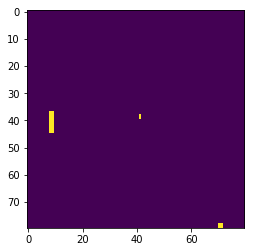

In [38]:
prev = prepro(obs)
plt.imshow(prev)

In [22]:
obs.shape

(210, 160, 3)

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

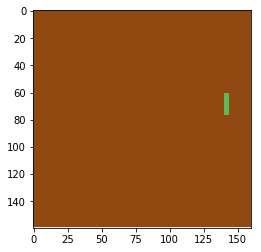

In [23]:
plt.imshow(obs[35:195, :, :])

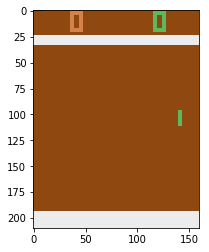

In [24]:
plt.imshow(obs)

In [39]:
obs, reward, done, info = env.step(1)

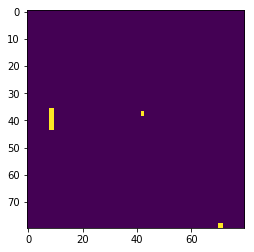

In [40]:
curr = prepro(obs)
plt.imshow(curr)

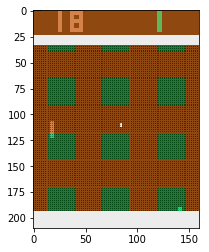

In [41]:
plt.imshow(obs)

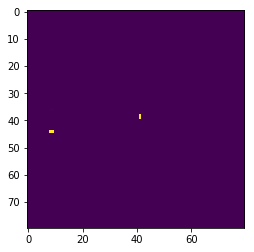

In [42]:
plt.imshow(curr - prev)